In [1]:
%matplotlib inline
import os
import re
import glob
import json
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from datetime import datetime
from typing import Sequence, Optional

from matplotlib import colormaps
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import TwoSlopeNorm

from scipy.stats import linregress, mannwhitneyu

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_analysis_arch_result_access.han_pipeline import get_mle_model_fitting
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_analysis import get_session_name_from_path
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import (
    annotate_movement_timing,
    add_lick_metadata_to_movements,
)

In [2]:
# Core Utilities
# =========================

def get_events_dict(df_trials, df_licks, tongue_kinematics):
    return {
        'goCue': (
            df_trials,
            'goCue_start_time_in_session',
            'trial'
        ),
        'firstLick': (
            df_licks,
            'timestamps',
            'trial',
            {'cue_response': True}  # Only include cue-response licks
        ),
        'firstMove': (
            tongue_kinematics,
            'time_in_session',
            'trial',
            {'min_after_cue': True}  # Only movements after go cue
        ),
        'reward': (
            df_trials,
            'reward_time_in_session',
            'trial'
            # No filters needed unless you want to restrict rewarded trials
        )
    }

def generate_event_times(df, time_col, trial_col, filters=None, cue_times=None):
    """
    Extracts a single event time per trial based on filtering and trial structure.

    Parameters:
        df (DataFrame): Source dataframe containing time data.
        time_col (str): Name of the column with event timestamps.
        trial_col (str): Column indicating trial identity.
        filters (dict): Optional filters. 
                        Special keys include 'cue_response' and 'min_after_cue'.
        cue_times (dict): Dict of trial -> go cue time, used for filtering.

    Returns:
        dict: trial_id -> event_time
    """
    times = {}
    for tr in df[trial_col].unique():
        sub = df[df[trial_col] == tr].copy()
        if filters:
            for fcol, fval in filters.items():
                if fcol == 'cue_response':
                    sub = sub[sub[fcol] == fval]
                elif fcol == 'min_after_cue':
                    t0 = cue_times.get(tr, np.inf)
                    sub = sub[sub[time_col] > t0]
        if sub.empty:
            continue
        if 'movement_id' in sub.columns:
            mid = sub['movement_id'].min()
            t_event = sub[sub['movement_id'] == mid][time_col].min()
        else:
            t_event = sub[time_col].min()
        times[tr] = t_event
    return times


def build_event_df(events_dict):
    """
    Constructs a DataFrame of event times for each trial.

    Parameters:
        events_dict (dict): event_name -> (df, time_col, trial_col[, filters])

    Returns:
        DataFrame: index = trials, columns = event times
    """
    if 'goCue' not in events_dict:
        raise ValueError("events_dict must contain a 'goCue' entry")
    
    cue_times = generate_event_times(*events_dict['goCue'])
    trials = sorted(cue_times.keys())
    E = pd.DataFrame(index=trials)

    for name, params in events_dict.items():
        df, time_col, trial_col, *rest = params
        filt = rest[0] if rest else {}
        times = generate_event_times(df, time_col, trial_col, filt, cue_times)
        E[name] = pd.Series(times)

    return E.astype(float)


def sort_trials_by_latency(trials, event_times, event1, event2):
    """
    Sorts trials by the latency between two events.

    Parameters:
        trials (list): Trial IDs.
        event_times (dict): event_name -> {trial_id -> time}.
        event1, event2 (str): Event names to compute latency.

    Returns:
        list: Sorted trial IDs.
    """
    return sorted(
        [
            tr for tr in trials
            if np.isfinite(event_times[event1].get(tr, np.nan))
            and np.isfinite(event_times[event2].get(tr, np.nan))
        ],
        key=lambda tr: event_times[event1][tr] - event_times[event2][tr]
    )


# =========================
# Spike Raster Matrix
# =========================

def compute_raster_matrix(spikes, trial_ids, event_times, pre=1.0, post=2.0, bin_size=0.001):
    """
    Converts spike times to a trial-by-time bin raster matrix.

    Parameters:
        spikes (1D array): All spike times.
        trial_ids (list): List of trial IDs.
        event_times (dict): trial_id -> alignment time.
        pre, post (float): Time before/after event to include (seconds).
        bin_size (float): Time bin width in seconds.

    Returns:
        tuple: (raster matrix, bin centers, trial_ids)
    """
    n_trials = len(trial_ids)
    n_bins = int(np.round((pre + post) / bin_size))
    raster = np.zeros((n_trials, n_bins), dtype=np.uint8)
    bins = np.linspace(-pre, post, n_bins, endpoint=False) + bin_size / 2

    for i, tr in enumerate(trial_ids):
        t0 = event_times.get(tr, np.nan)
        if np.isnan(t0):
            continue
        rel = spikes - t0
        sel = (rel >= -pre) & (rel < post)
        rel = rel[sel]
        idx = ((rel + pre) / bin_size).astype(int)
        for j in idx:
            if 0 <= j < n_bins:
                raster[i, j] += 1
    return raster, bins, trial_ids


# =========================
# Plotting Utilities
# =========================

def plot_spikes(raster, bins, ax=None, color='black'):
    """
    Plot spike raster given binary/count matrix.

    Parameters:
        raster (2D array): Trials x time bins.
        bins (1D array): Time bin centers.
        ax (Axes): Optional matplotlib axis.
        color (str): Line color.

    Returns:
        Axes: Modified axis.
    """
    if ax is None:
        fig, ax = plt.subplots()
    for i, row in enumerate(raster):
        spk_idx = np.nonzero(row)[0]
        ax.vlines(bins[spk_idx], i + 0.5, i + 1.5, color=color)
    return ax


def plot_event_lines(ax, ordered_trials, events):
    """
    Overlay event-aligned lines on spike raster plot.

    Parameters:
        ax (Axes): Matplotlib axis.
        ordered_trials (list): List of trial indices in display order.
        events (dict): event_name -> {'times': {trial_idx: t_rel}, 'style': dict}

    Returns:
        Axes: Modified axis.
    """
    n = len(ordered_trials)
    for name, info in events.items():
        times_dict = info['times']
        style = info.get('style', {})
        for i in range(n):
            t_rel = times_dict.get(i)
            if t_rel is not None:
                style = info.get('style', {}).copy()
                if i == 0:
                    style['label'] = name
                ax.axvline(t_rel, ymin=i/n, ymax=(i+1)/n, **style)
    return ax


# =========================
# RasterPlotter Class
# =========================

class RasterPlotter:
    """
    Encapsulates raster generation and plotting routines.
    """

    def __init__(self, spikes, trial_ids, event_times, pre=1.0, post=2.0, bin_size=0.001):
        self.spikes = spikes
        self.trial_ids = trial_ids
        self.event_times = event_times
        self.pre = pre
        self.post = post
        self.bin_size = bin_size
        self.raster, self.bins, self.ordered = compute_raster_matrix(
            spikes, trial_ids, event_times, pre, post, bin_size
        )

    def plot_raster(self, ax=None, spike_color='black'):
        """
        Plot spike raster only.
        """
        ax = plot_spikes(self.raster, self.bins, ax=ax, color=spike_color)
        ax.set_xlim(-self.pre, self.post)
        ax.set_ylim(0.5, len(self.ordered) + 0.5)
        ax.set_ylabel('Trial')
        ax.set_xlabel('Time (s)')
        return ax

    def add_events(self, ax, events):
        """
        Add vertical event lines to an existing raster.
        """
        return plot_event_lines(ax, self.ordered, events)

    def plot_with_events(self, events, ax=None, spike_color='black'):
        """
        Plot raster with overlaid event markers.
        """
        ax = self.plot_raster(ax=ax, spike_color=spike_color)
        ax = self.add_events(ax, events)
        return ax


# =========================
# PSTH Utilities
# =========================

def compute_psth(raster, bin_size=0.001, trials=None, as_rate=True):
    """
    Compute a Peri-Stimulus Time Histogram (PSTH) from spike raster.

    Parameters:
        raster (2D array): Trials x time bins.
        bin_size (float): Width of time bin in seconds.
        trials (list): Optional list of trial indices to include.
        as_rate (bool): If True, normalize to spikes/sec.

    Returns:
        tuple: (psth, trial_count)
    """
    if trials is not None:
        data = raster[trials, :]
        count = len(trials)
    else:
        data = raster
        count = raster.shape[0]

    psth = data.sum(axis=0)
    if as_rate:
        psth = psth / (bin_size * count)
    return psth, count


def smooth_vector(vec, bin_size, sigma=0.025):
    """
    Apply causal Gaussian smoothing to a vector.

    Parameters:
        vec (1D array): Input signal.
        bin_size (float): Bin size in seconds.
        sigma (float): Std dev of Gaussian in seconds.

    Returns:
        1D array: Smoothed signal.
    """
    L = int(np.ceil(3 * sigma / bin_size))
    lags = np.arange(L+1) * bin_size
    gauss = np.exp(-0.5 * (lags / sigma) ** 2)
    gauss /= gauss.sum()
    smooth = np.convolve(vec, gauss, mode='full')[:len(vec)]
    return smooth


def plot_psth(
    bins,
    psth,
    psth_smooth=None,
    ax=None,
    label='PSTH',
    plot_raw=True,
    color=None,
):
    """
    Plot raw and/or smoothed PSTH.

    Parameters
    ----------
    bins : 1D array
        Time bin centers.
    psth : 1D array
        Raw PSTH.
    psth_smooth : 1D array, optional
        Smoothed PSTH.
    ax : matplotlib Axes, optional
        Axis to plot into. If None, a new figure/axis is created.
    label : str
        Legend label.
    plot_raw : bool, default=True
        Whether to plot the raw PSTH trace.
    color : str, optional
        Matplotlib color for the trace(s). If None, uses default cycle.

    Returns
    -------
    ax : matplotlib Axes
        The axis containing the plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    if plot_raw and psth is not None:
        ax.plot(bins, psth, label=label, color=color)

    if psth_smooth is not None:
        # Use same label if raw is hidden, otherwise append
        lbl = label if not plot_raw else f"{label} (smoothed)"
        ax.plot(bins, psth_smooth, label=lbl, color=color)

    ax.axvline(0, color='k', linestyle='--')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Firing rate (spk/s)')
    ax.legend()
    return ax



In [3]:
#wrappers

def make_rp_and_events(
    spikes,
    trials: list,
    event_dicts: dict,
    align_by: str,
    sort_by: str,
    events_to_plot: Sequence[str] = None,
    pre: float = 1.0,
    post: float = 2.0,
    bin_size: float = 0.001,
):
    """
    spikes           : 1D array of spike times
    trials           : list of trial IDs (Ev.index)
    event_dicts      : {event_name -> {trial_id -> absolute_time}}
    align_by         : which event to align each trial on
    sort_by          : which event to sort trials by (latency from align_by)
    events_to_plot   : subset of event_names to overlay (defaults to all but align_by)
    pre, post, bin_size : raster params
    """
    # 1) sort trials
    ordered = sort_trials_by_latency(
        trials=trials,
        event_times=event_dicts,    # can look up both sort_by & align_by
        event1=sort_by,
        event2=align_by,
    )

    # 2) make raster aligned to align_by
    align_times = event_dicts[align_by]
    rp = RasterPlotter(spikes, ordered, align_times,
                       pre=pre, post=post, bin_size=bin_size)

    # 3) pick events
    if events_to_plot is None:
        events_to_plot = [e for e in event_dicts if e != align_by]

    # 4) build relative‐time dicts
    events = {}
    for ix, name in enumerate(events_to_plot):
        times_rel = {}
        for i, tr in enumerate(ordered):
            t_abs = event_dicts[name].get(tr)
            t0    = align_times.get(tr)
            if t_abs is not None and t0 is not None:
                times_rel[i] = t_abs - t0
        events[name] = {
            'times': times_rel,
            'style': {'color': f"C{ix}", 'linestyle':'--', 'linewidth':2}
        }

    return rp, events


def plot_unit_panels(spikes, unit_n,
                     trials,
                     event_dicts,
                     combos,
                     events_to_plot=None,
                     pre=1.0,
                     post=2.0,
                     bin_size=0.001,
                     sigma=0.025):
    """
    spikes         : 1D array of spike times
    trials         : list of trial IDs
    event_dicts    : {event_name -> {trial_id -> event_time}}
    combos         : list of (align_by, sort_by) pairs
    events_to_plot : list of event_names to overlay (defaults to all but align_by)
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex='col')

    for col, (align_by, sort_by) in enumerate(combos):
        # build the RasterPlotter + event overlays
        rp, events = make_rp_and_events(
            spikes,
            trials,
            event_dicts,
            align_by=align_by,
            sort_by=sort_by,
            events_to_plot=events_to_plot,  # or None to use all but align_by
            pre=pre,
            post=post,
            bin_size=bin_size
        )

        # top row: raster + event lines
        ax_r = axes[0, col]
        rp.plot_raster(ax=ax_r, spike_color='black')
        rp.add_events(ax_r, events)
        ax_r.set_title(f'align: {align_by}   sort: {sort_by}')
        if col == 0:
            ax_r.set_ylabel('Trial')
            ax_r.legend(loc='upper left', title='Events')
        ax_r.set_xlabel(None)

        # bottom row: PSTH
        ax_p = axes[1, col]
        psth, _    = compute_psth(rp.raster, bin_size=rp.bin_size)
        psth_sm    = smooth_vector(psth, bin_size=rp.bin_size, sigma=sigma)
        plot_psth(rp.bins, psth, psth_sm, ax=ax_p, label='PETH')
        if col == 0:
            ax_p.set_ylabel('Firing rate (spk/s)')
        ax_p.set_xlabel(f'Time from {align_by} (s)')
    plt.suptitle(f'Unit {unit_n}', fontsize=16)
    plt.tight_layout()
    return fig

In [4]:

with open('/root/capsule/data/LC-NE_scratch_data_06-14-2025/combined/combine_unit_tbl/combined_unit_tbl_06122025.pkl', 'rb') as file:
    combined_ephys_data = pickle.load(file)

In [5]:
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_analysis import get_session_name_from_path

# ---------- criteria filter ----------
criteria = {
    "isi_violations": {"bounds": [0.0, 0.1]},
    "p_max": {"bounds": [0.5, 1.0]},
    "lat_max_p": {"bounds": [0.005, 0.02]},
    "eu": {"bounds": [0.0, 0.25]},
    "corr": {"bounds": [0.95, 1.0]},
    "qc_pass": {"items": [True]},
    "peak": {"bounds": [-1000, 0]},
    "trial_count": {"bounds": [100, 2000]},
    "in_df": {"items": [True]},
}

mask = pd.Series(True, index=combined_ephys_data.index)
for col, rule in criteria.items():
    if "bounds" in rule:
        lo, hi = rule["bounds"]
        mask &= combined_ephys_data[col].between(lo, hi)
    if "items" in rule:
        mask &= combined_ephys_data[col].isin(rule["items"])

criteria_filtered = combined_ephys_data.loc[mask].copy()

# ---------- session allow (prefix-based) ----------
pred_csv_list = [
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_716325_2024-05-31_10-31-14/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_717121_2024-06-15_10-00-58/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_717259_2024-06-28_11-17-19/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_717263_2024-07-24_10-40-05/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-20_13-26-07/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-21_13-28-24/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-22_13-09-11/bottom_camera.csv",
    "/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-23_14-19-57/bottom_camera.csv",
]

def get_session_prefix(s: str) -> str:
    # 'behavior_751004_2024-12-20_13-26-07' -> 'behavior_751004_2024-12-20'
    return re.sub(r'_\d{2}-\d{2}-\d{2}$', '', s)

session_order_full   = [get_session_name_from_path(p) for p in pred_csv_list]
session_prefix_order = [get_session_prefix(s) for s in session_order_full]
session_prefix_allow = set(session_prefix_order)

# add prefix columns
combined_ephys_data = combined_ephys_data.copy()
combined_ephys_data.loc[:, "session_prefix"]  = combined_ephys_data["session"].map(get_session_prefix)
criteria_filtered.loc[:, "session_prefix"]     = criteria_filtered["session"].map(get_session_prefix)

# ---------- summary table (before vs. after, for queried prefixes only) ----------
counts_before = combined_ephys_data.groupby("session_prefix").size().rename("units_before")
counts_after  = criteria_filtered.groupby("session_prefix").size().rename("units_after")

base = pd.concat([counts_before, counts_after], axis=1).reindex(session_prefix_order)
base["units_before"] = base["units_before"].astype("Int64")        # keep NA if not present before
base["units_after"]  = base["units_after"].fillna(0).astype(int)   # 0 if none survived

session_summary_allowed = base.reset_index().rename(columns={"index": "session_prefix"})

# ---------- final filtered units (criteria + session prefix allow) ----------
filtered_ephys = criteria_filtered.loc[
    criteria_filtered["session_prefix"].isin(session_prefix_allow)
].copy()

# ---------- prints ----------
print(f"Filtered units: {len(filtered_ephys)} / {len(combined_ephys_data)}")
print(session_summary_allowed.to_string(index=False))


Filtered units: 13 / 8182
            session_prefix  units_before  units_after
behavior_716325_2024-05-31           281            3
behavior_717121_2024-06-15           243            1
behavior_717259_2024-06-28          <NA>            0
behavior_717263_2024-07-24          <NA>            0
behavior_751004_2024-12-20           248            3
behavior_751004_2024-12-21           176            3
behavior_751004_2024-12-22           110            1
behavior_751004_2024-12-23           177            2


In [6]:
filtered_ephys.columns

Index(['session', 'unit', 'qc_pass', 'opto_tagged', 'opto_tagging_pre',
       'opto_tagging_post', 'anti', 'in_df', 'trial_count', 'p_max',
       'lat_max_p', 'isi_violations', 'snr', 'eu', 'corr', 'amp', 'peak', 'wf',
       'wf_aligned', 'wf_2d', 'probe', 'y_loc', 'rec_side', 'top', 'bottom',
       'x_ccf', 'y_ccf', 'z_ccf', 'session_prefix'],
      dtype='object')

In [7]:
# #single session data processing example
# with open('/root/capsule/data/LC-NE_scratch_data_06-14-2025/716325/behavior_716325_2024-05-31_10-31-14/ephys/opto/curated/behavior_716325_2024-05-31_10-31-14_curated_soma_opto_tagging_summary.pkl', 'rb') as file:
#     ephys_session_data = pickle.load(file)

# ephys_data = ephys_session_data[ephys_session_data['unit_id'].isin(session_units)].copy()

# first_go_cue_time = df_trials['goCue_start_time_raw'].iloc[0]

# ephys_data['spike_times_in_session'] = ephys_data['spike_times'].apply(lambda x: x - first_go_cue_time)

In [8]:

ROOT_SCRATCH = "/root/capsule/data/LC-NE_scratch_data_06-14-2025"

def get_session_prefix(s: str) -> str:
    # 'behavior_751004_2024-12-20_13-26-07' -> 'behavior_751004_2024-12-20'
    return re.sub(r'_\d{2}-\d{2}-\d{2}$', '', s)

def get_animal_id(session: str) -> str:
    m = re.match(r'^behavior_(\d+)_', session)
    if not m:
        raise ValueError(f"Cannot parse animal id from session: {session}")
    return m.group(1)

def find_summary_pkl(root: str, session: str) -> Optional[Path]:  # <-- fixed
    """Try exact path; if missing, fall back to prefix glob search."""
    animal = get_animal_id(session)
    exact = Path(root) / animal / session / "ephys" / "opto" / "curated" / f"{session}_curated_soma_opto_tagging_summary.pkl"
    if exact.exists():
        return exact
    pref = get_session_prefix(session)
    candidates = list((Path(root) / animal).glob(f"{pref}_*/ephys/opto/curated/*_curated_soma_opto_tagging_summary.pkl"))
    return candidates[0] if candidates else None

def ensure_spike_times_column(df: pd.DataFrame, session_dir: Path) -> pd.DataFrame:
    """Attach 'spike_times' from NWB if possible; else create empty column."""
    if "spike_times" in df.columns:
        return df
    try:
        from pynwb import NWBHDF5IO
        nwb_files = list(session_dir.rglob("*.nwb"))
        if nwb_files:
            with NWBHDF5IO(str(nwb_files[0]), "r") as io:
                nwb = io.read()
                units_df = nwb.units.to_dataframe()  # index = unit id
            df = df.merge(units_df[["spike_times"]], left_on="unit_id", right_index=True, how="left")
            if "spike_times" not in df.columns:
                df["spike_times"] = None
            return df
    except Exception as e:
        print(f"[warn] Could not attach spike_times from NWB: {e}")
    df = df.copy()
    df["spike_times"] = None
    return df

# ---- main loop (same as before) ----
units_with_spikes = []
for session, subdf in filtered_ephys.groupby("session"):
    pkl_path = find_summary_pkl(ROOT_SCRATCH, session)
    if pkl_path is None:
        print(f"[skip] No summary .pkl found for {session}")
        continue

    with open(pkl_path, "rb") as f:
        ephys_session_data = pickle.load(f)
    if not isinstance(ephys_session_data, pd.DataFrame):
        try:
            ephys_session_data = pd.DataFrame(ephys_session_data)
        except Exception:
            print(f"[skip] Summary not a DataFrame for {session}")
            continue

    session_dir = pkl_path.parents[3]  # .../{animal}/{session}/
    ephys_session_data = ensure_spike_times_column(ephys_session_data, session_dir)

    unit_ids = subdf["unit"].unique()
    ephys_data = (
        ephys_session_data[ephys_session_data["unit_id"].isin(unit_ids)]
        .copy()
        .assign(session=session)
    )
    print(f"[ok] {session}: {len(ephys_data)}/{len(unit_ids)} units with 'spike_times' column")
    units_with_spikes.append(ephys_data)

units_with_spikes = (
    pd.concat(units_with_spikes, ignore_index=True)
    if units_with_spikes else pd.DataFrame(columns=["session","unit_id","spike_times"])
)
print("Final units_with_spikes shape:", units_with_spikes.shape)


[ok] behavior_716325_2024-05-31_10-31-14: 3/3 units with 'spike_times' column
[ok] behavior_717121_2024-06-15_10-00-58: 1/1 units with 'spike_times' column
[ok] behavior_751004_2024-12-20_13-26-11: 3/3 units with 'spike_times' column
[ok] behavior_751004_2024-12-21_13-28-28: 3/3 units with 'spike_times' column
[ok] behavior_751004_2024-12-22_13-09-17: 1/1 units with 'spike_times' column
[ok] behavior_751004_2024-12-23_14-20-03: 2/2 units with 'spike_times' column
Final units_with_spikes shape: (13, 50)


In [25]:
units_with_spikes.columns

Index(['bl_max_p', 'p_max', 'p_mean', 'lat_max_p', 'lat_mean', 'euc_max_p',
       'corr_max_p', 'opto_pass', 'amp', 'peak', 'real_unit', 'y_loc',
       'pass_count', 'spike_times', 'ks_unit_id', 'isi_violations_ratio',
       'firing_rate', 'presence_ratio', 'amplitude_cutoff', 'decoder_label',
       'depth', 'snr', 'waveform_mean', 'waveform_sd', 'default_qc', 'peak_wf',
       'peak_wf_aligned', 'wf_2d', 'LC_range_top', 'LC_range_bottom',
       'tagged_loc', 'tagged', 'unit_id', 'amplitude_opt', 'peak_wf_opt',
       'mat_wf_opt', 'peak_wf_opt_aligned', 'mat_wf_raw', 'mat_wf_raw_aligned',
       'peak_waveform_raw', 'peak_waveform_raw_aligned', 'amplitude_raw',
       'peak_raw', 'mat_wf_raw_fake', 'mat_wf_raw_fake_aligned',
       'peak_waveform_raw_fake', 'peak_waveform_raw_fake_aligned',
       'amplitude_raw_fake', 'peak_raw_fake', 'session'],
      dtype='object')

In [9]:

# Root where kinematics/intermediate data live
KIN_ROOT = Path("/root/capsule/scratch/session_analysis_in_distribution")

def find_scratch_session_dir(session: str) -> Path:
    """Return scratch folder for a session; try exact, else prefix glob."""
    exact = KIN_ROOT / session
    if exact.exists():
        return exact
    pref = get_session_prefix(session)
    hits = sorted(KIN_ROOT.glob(pref + "*"))
    if not hits:
        raise FileNotFoundError(f"No scratch folder for session/prefix: {session} / {pref}")
    return hits[0]

def load_intermediate_data(session_dir: Path) -> dict:
    """Load the four intermediate parquet tables for a session."""
    idir = session_dir / "intermediate_data"
    return {
        "movs":   pd.read_parquet(idir / "tongue_movs.parquet"),
        "trials": pd.read_parquet(idir / "nwb_df_trials.parquet"),
        "licks":  pd.read_parquet(idir / "nwb_df_licks.parquet"),
        "kins":   pd.read_parquet(idir / "tongue_kins.parquet"),
    }



In [10]:
# #raster plot, 3 panels/alignments per unit, pdf save

# # --- loop over units, loading per-session data on demand ---
# _per_session_cache = {}  # session -> dict with movs/trials/licks/kins

# PDF_PATH = Path("/root/capsule/scratch/figures/LC_movement_raster_psth_alignments.pdf")
# PDF_PATH.parent.mkdir(parents=True, exist_ok=True)

# with PdfPages(PDF_PATH) as pdf:

#     for row in units_with_spikes.itertuples(index=False):
#         session = row.session
#         unit_session = str(row.unit_id) +' ' + str(session)
#         spike_times = row.spike_times  # your per-unit spikes
#         if session not in _per_session_cache:
#             sdir = find_scratch_session_dir(session)
#             _per_session_cache[session] = load_intermediate_data(sdir)

#         data = _per_session_cache[session]
#         tongue_movements = data["movs"]
#         df_trials        = data["trials"]
#         df_licks         = data["licks"]
#         tongue_kinematics= data["kins"]

#         first_go_cue_time = df_trials['goCue_start_time_raw'].iloc[0]
#         spike_times_in_session = spike_times - first_go_cue_time

#         #events
#         events_dict = get_events_dict(df_trials, df_licks, tongue_kinematics)
#         E  = build_event_df(events_dict)
#         Ev = E.dropna(subset=['goCue','firstLick','firstMove']).copy()

#         #trial orders and combos
#         trials = list(Ev.index)
#         event_dicts = {name: Ev[name].to_dict() for name in Ev.columns}
#         combos = [
#             ('goCue',     'firstMove'),
#             ('firstMove', 'firstLick'),
#             ('firstLick', 'firstMove'),
#         ]

#         fig = plot_unit_panels(
#             spike_times_in_session,
#             unit_session,
#             trials,
#             event_dicts,
#             combos,
#             events_to_plot=['goCue', 'firstMove', 'firstLick', 'reward'],  # or None
#             pre=1.0,
#             post=2.0,
#             bin_size=0.001,
#             sigma=0.025
#         )
#         # plt.show()
#         pdf.savefig(fig, bbox_inches="tight")
#         plt.close(fig)



In [11]:


# # --- loop over units, loading per-session data on demand ---
# _per_session_cache = {}  # session -> dict with movs/trials/licks/kins

# PDF_PATH = Path("/root/capsule/scratch/figures/LC_movement_raster_psth_movenumber.pdf")
# PDF_PATH.parent.mkdir(parents=True, exist_ok=True)

# plt.ioff()  # (optional) speed up headless plotting

# with PdfPages(PDF_PATH) as pdf:
#     for row in units_with_spikes.itertuples(index=False):
#         session = row.session
#         unit_session = f"{row.unit_id} {session}"
#         spike_times = row.spike_times

#         # Load intermediate data (cached per session)
#         if session not in _per_session_cache:
#             sdir = find_scratch_session_dir(session)
#             _per_session_cache[session] = load_intermediate_data(sdir)

#         data = _per_session_cache[session]
#         tongue_movements = data["movs"].copy()
#         df_trials        = data["trials"]
#         df_licks         = data["licks"]
#         tongue_kinematics= data["kins"]

#         # Align spikes to session time
#         first_go_cue_time = df_trials['goCue_start_time_raw'].iloc[0]
#         spike_times_in_session = spike_times - first_go_cue_time

#         # --- events tables ---
#         events_dict = get_events_dict(df_trials, df_licks, tongue_kinematics)
#         E  = build_event_df(events_dict)
#         Ev = E.dropna(subset=['goCue','firstLick','firstMove']).copy()
#         if Ev.empty:
#             print(f"[skip] {unit_session}: no valid trials after dropping NaNs for goCue/firstLick/firstMove")
#             continue

#         # --- annotate movements per trial if not already annotated ---
#         if 'cue_response_movement_number' not in tongue_movements.columns:
#             tongue_movements = add_lick_metadata_to_movements(
#                 tongue_movements,
#                 df_licks,
#                 fields=['timestamps']
#             )
#             tongue_movements = tongue_movements.rename(columns={'timestamps': 'lick_time'})

#             # Annotate movements using trials
#             tongue_movements = annotate_movement_timing(tongue_movements, df_trials)


#         # Robust per-trial cue_response_movement_number
#         trial_crmn = (
#             tongue_movements.groupby('trial')['cue_response_movement_number']
#               .apply(lambda s: s.dropna().astype('Int64').iloc[0] if s.dropna().size else pd.NA)
#         )

#         trials_cr1 = set(trial_crmn[trial_crmn == 1].index.tolist())
#         trials_cr2 = set(trial_crmn[trial_crmn == 2].index.tolist())

#         # Keep only trials that exist in Ev
#         valid_trials = set(Ev.index)
#         trials_cr1 = sorted(trials_cr1 & valid_trials)
#         trials_cr2 = sorted(trials_cr2 & valid_trials)

#         # Order by latency to firstMove
#         sort_key = 'firstMove'
#         lat = (Ev[sort_key] - Ev['goCue']).dropna()
#         ordered_cr1 = sorted(trials_cr1, key=lambda tr: lat.get(tr, np.inf))
#         ordered_cr2 = sorted(trials_cr2, key=lambda tr: lat.get(tr, np.inf))

#         combined_trials = ordered_cr1 + ordered_cr2
#         split_idx = len(ordered_cr1)
#         if len(combined_trials) == 0:
#             print(f"[skip] {unit_session}: no trials in CR1/CR2 overlap with Ev")
#             continue

#         # Build event dicts
#         event_dicts = {n: Ev[n].to_dict() for n in Ev.columns}

#         # Raster aligned to goCue
#         align_key = 'goCue'
#         align_times = event_dicts[align_key]
#         rp = RasterPlotter(
#             spike_times_in_session,
#             combined_trials,
#             align_times,
#             pre=1.5, post=1.5, bin_size=0.001
#         )

#         # Relative event overlays
#         events = {}
#         for ix, name in enumerate(['goCue','firstMove','firstLick','reward']):
#             times_rel = {}
#             for i, tr in enumerate(combined_trials):
#                 t_abs = event_dicts[name].get(tr)
#                 t0    = align_times.get(tr)
#                 if t_abs is not None and t0 is not None:
#                     times_rel[i] = t_abs - t0
#             events[name] = {'times': times_rel,
#                             'style': {'color': f"C{ix}", 'linestyle':'--', 'linewidth':2}}

#         # Compute group PSTHs
#         raster_cr1 = rp.raster[:split_idx, :]   # CR==1
#         raster_cr2 = rp.raster[split_idx:, :]   # CR==2
#         psth1, _ = compute_psth(raster_cr1, bin_size=rp.bin_size)
#         psth2, _ = compute_psth(raster_cr2, bin_size=rp.bin_size)

#         # Smooth
#         psth1_sm = smooth_vector(psth1, bin_size=rp.bin_size, sigma=0.025)
#         psth2_sm = smooth_vector(psth2, bin_size=rp.bin_size, sigma=0.025)

#         # Plot
#         fig, (ax_raster, ax_psth) = plt.subplots(
#             2, 1, figsize=(8, 7), sharex=True,
#             gridspec_kw={'height_ratios':[3,1]}
#         )

#         # Raster
#         rp.plot_raster(ax_raster, spike_color='black')
#         rp.add_events(ax_raster, events)
#         ax_raster.axhline(split_idx, color='gray', linestyle=':', linewidth=1)
#         ax_raster.set_ylabel('Trials')

#         # Title = unit_session (as requested)
#         ax_raster.set_title(unit_session)

#         # PSTHs (smoothed only)
#         plot_psth(rp.bins, psth1, psth1_sm, ax=ax_psth, label='CR==1', plot_raw=False, color='black')
#         plot_psth(rp.bins, psth2, psth2_sm, ax=ax_psth, label='CR==2', plot_raw=False, color='gray')
#         ax_psth.set_xlabel('Time from goCue (s)')
#         ax_psth.set_ylabel('Firing rate (spk/s)')
#         ax_psth.legend(frameon=False)

#         plt.tight_layout()

#         # Save page to the multi-page PDF
#         pdf.savefig(fig, bbox_inches="tight")
#         plt.close(fig)

# print(f"✅ Saved {PDF_PATH}")


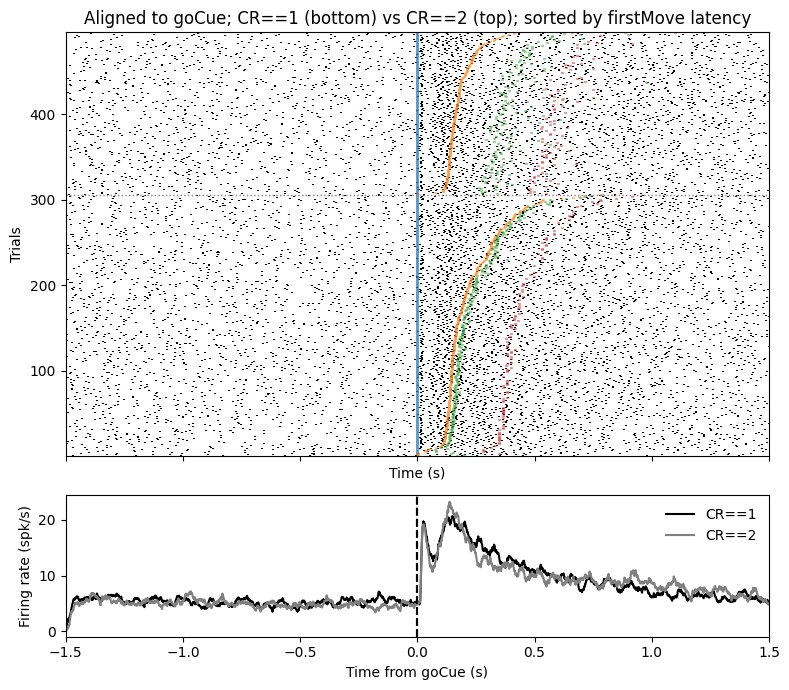

In [11]:
#single unit example (CR1 vs CR2 raster + PSTH)

_per_session_cache = {}  # session -> dict with movs/trials/licks/kins


row = units_with_spikes.iloc[0]
session = row.session
spike_times = row.spike_times  # your per-unit spikes
if session not in _per_session_cache:
    sdir = find_scratch_session_dir(session)
    _per_session_cache[session] = load_intermediate_data(sdir)

data = _per_session_cache[session]
tongue_movements = data["movs"]
df_trials        = data["trials"]
df_licks         = data["licks"]
tongue_kinematics= data["kins"]

first_go_cue_time = df_trials['goCue_start_time_raw'].iloc[0]
spike_times_in_session = spike_times - first_go_cue_time

#events
events_dict = get_events_dict(df_trials, df_licks, tongue_kinematics)
E  = build_event_df(events_dict)
Ev = E.dropna(subset=['goCue','firstLick','firstMove']).copy()

# # # trials
# Add lick time from licks_df
tongue_movements = add_lick_metadata_to_movements(
    tongue_movements,
    df_licks,
    fields=['timestamps']
)
tongue_movements = tongue_movements.rename(columns={'timestamps': 'lick_time'})

# Annotate movements using trials
tongue_movements = annotate_movement_timing(tongue_movements, df_trials)

# Robust per-trial cue_response_movement_number (take first non-null if duplicates)
trial_crmn = (
    tongue_movements.groupby('trial')['cue_response_movement_number']
      .apply(lambda s: s.dropna().astype('Int64').iloc[0] if s.dropna().size else pd.NA)
)
trials_cr1 = set(trial_crmn[trial_crmn == 1].index.tolist())
trials_cr2 = set(trial_crmn[trial_crmn == 2].index.tolist())

# Keep only trials that exist in your events table Ev
valid_trials = set(Ev.index)
trials_cr1 = sorted(trials_cr1 & valid_trials)
trials_cr2 = sorted(trials_cr2 & valid_trials)
# latency
sort_key = 'firstMove'
lat = (Ev[sort_key] - Ev['goCue']).dropna()
ordered_cr1 = sorted(trials_cr1, key=lambda tr: lat.get(tr, np.inf))
ordered_cr2 = sorted(trials_cr2, key=lambda tr: lat.get(tr, np.inf))

# Combined order for the *single* raster: CR==1 first (bottom), CR==2 second (top)
combined_trials = ordered_cr1 + ordered_cr2
split_idx = len(ordered_cr1)  # row index where CR==2 starts

#plotting
# Build align/event dicts just like your wrapper does
event_dicts = {n: Ev[n].to_dict() for n in Ev.columns}

# Raster aligned to goCue, sorted by firstMove within our combined order
# (We already pre-sorted combined_trials, so pass as-is.)
align_key = 'goCue'
align_times = event_dicts[align_key]
rp = RasterPlotter(
    spike_times_in_session,
    combined_trials,
    align_times,
    pre=1.5, post=1.5, bin_size=0.001
)

# Relative event overlays (goCue, firstMove, firstLick, reward)
events = {}
for ix, name in enumerate(['goCue','firstMove','firstLick','reward']):
    times_rel = {}
    for i, tr in enumerate(combined_trials):
        t_abs = event_dicts[name].get(tr)
        t0    = align_times.get(tr)
        if t_abs is not None and t0 is not None:
            times_rel[i] = t_abs - t0
    events[name] = {'times': times_rel,
                    'style': {'color': f"C{ix}", 'linestyle':'--', 'linewidth':2}}

# Compute group PSTHs
raster_cr1 = rp.raster[:split_idx, :]   # rows corresponding to CR==1
raster_cr2 = rp.raster[split_idx:, :]   # rows corresponding to CR==2

psth1, _ = compute_psth(raster_cr1, bin_size=rp.bin_size)  # CR==1
psth2, _ = compute_psth(raster_cr2, bin_size=rp.bin_size)  # CR==2

# Smooth
psth1_sm = smooth_vector(psth1, bin_size=rp.bin_size, sigma=0.025)
psth2_sm = smooth_vector(psth2, bin_size=rp.bin_size, sigma=0.025)

# Plot with your function
fig, (ax_raster, ax_psth) = plt.subplots(2, 1, figsize=(8, 7),
                                         sharex=True,
                                         gridspec_kw={'height_ratios':[3,1]})

# Raster
rp.plot_raster(ax_raster, spike_color='black')
rp.add_events(ax_raster, events)
ax_raster.set_title(f'Aligned to {align_key}; CR==1 (bottom) vs CR==2 (top); sorted by {sort_key} latency')
ax_raster.axhline(split_idx, color='gray', linestyle=':', linewidth=1)
ax_raster.set_ylabel('Trials')

# PSTHs — only smoothed, with custom colors
plot_psth(rp.bins, psth1, psth1_sm,
          ax=ax_psth, label='CR==1',
          plot_raw=False, color='black')
plot_psth(rp.bins, psth2, psth2_sm,
          ax=ax_psth, label='CR==2',
          plot_raw=False, color='gray')

ax_psth.set_xlabel('Time from goCue (s)')
ax_psth.set_ylabel('Firing rate (spk/s)')
ax_psth.legend(frameon=False)
plt.tight_layout()
plt.show()

In [13]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from typing import Dict, Iterable, Tuple

# -----------------------------
# User-adjustable parameters
# -----------------------------
ALIGN_KEY       = "goCue"       # 'goCue', 'firstMove', 'firstLick', 'reward', etc.
COUNT_WINDOW_S  = (0.0, 0.100)  # start, stop (seconds) relative to alignment
MIN_TRIALS_PER_GROUP = 8        # guardrail to avoid tiny-n tests
SAVE_COUNTS_CSV = Path("/root/capsule/scratch/figures/LC_counts_by_trial.csv")
SAVE_STATS_CSV  = Path("/root/capsule/scratch/figures/LC_counts_stats_by_unit.csv")

# -----------------------------
# Helpers
# -----------------------------
def count_spikes_in_window(spike_times_sorted: np.ndarray, t0: float, window: Tuple[float,float]) -> int:
    """
    Count spikes in [t0 + window[0], t0 + window[1]) assuming spike_times_sorted is sorted.
    """
    a, b = t0 + window[0], t0 + window[1]
    if not np.isfinite(a) or not np.isfinite(b):
        return 0
    # searchsorted for O(log N) bounds
    i0 = np.searchsorted(spike_times_sorted, a, side="left")
    i1 = np.searchsorted(spike_times_sorted, b, side="left")
    return int(i1 - i0)

def get_trial_alignment_times(Ev: pd.DataFrame, align_key: str, trials: Iterable[int]) -> Dict[int, float]:
    """
    Map trial -> alignment time (float) for the requested align_key, skipping NaNs.
    """
    col = Ev[align_key]
    out = {}
    for tr in trials:
        t = col.get(tr, np.nan)
        if pd.notna(t):
            out[tr] = float(t)
    return out

def robust_trial_crmn(tongue_movements: pd.DataFrame) -> pd.Series:
    """
    For each trial, return a single cue_response_movement_number (Int64) or NA.
    """
    return (
        tongue_movements.groupby('trial')['cue_response_movement_number']
        .apply(lambda s: s.dropna().astype('Int64').iloc[0] if s.dropna().size else pd.NA)
    )

def mannwhitney_summary(x: np.ndarray, y: np.ndarray) -> dict:
    """
    Nonparametric test on counts. Returns p, U, effect-size estimate (Cliff's delta-style approx).
    """
    # scipy returns U; we compute a simple effect-size proxy
    if len(x) == 0 or len(y) == 0:
        return dict(p=np.nan, U=np.nan, effect=np.nan)
    stat = mannwhitneyu(x, y, alternative="two-sided")
    # Effect proxy: difference of means (counts), also report rate diff.
    eff = float(np.mean(x) - np.mean(y))
    return dict(p=float(stat.pvalue), U=float(stat.statistic), effect=eff)

# -----------------------------
# Main per-unit analysis (no plots)
# -----------------------------
_per_session_cache = {}  # session -> dict with movs/trials/licks/kins

all_trial_counts_records = []   # one row per (unit, trial)
all_unit_stats_records   = []   # one row per unit

for row in units_with_spikes.itertuples(index=False):
    session = row.session
    unit_id = row.unit_id
    unit_session = f"{unit_id} {session}"
    spike_times = np.asarray(row.spike_times, dtype=float)

    # Load intermediate data (cached per session)
    if session not in _per_session_cache:
        sdir = find_scratch_session_dir(session)
        _per_session_cache[session] = load_intermediate_data(sdir)

    data = _per_session_cache[session]
    tongue_movements = data["movs"].copy()
    df_trials        = data["trials"]
    df_licks         = data["licks"]
    tongue_kinematics= data["kins"]

    # Align spikes to session time
    first_go_cue_time = df_trials['goCue_start_time_raw'].iloc[0]
    spike_times_in_session = spike_times - float(first_go_cue_time)
    spike_times_in_session.sort()  # ensure sorted for searchsorted

    # --- events tables (per your utils) ---
    events_dict = get_events_dict(df_trials, df_licks, tongue_kinematics)
    E  = build_event_df(events_dict)
    # we need trials with non-NaN alignment + other key events as you prefer
    Ev = E.dropna(subset=['goCue'])  # minimally require align key; you can broaden if needed
    if Ev.empty:
        print(f"[skip] {unit_session}: no valid trials after dropping NaNs for {ALIGN_KEY}")
        continue

    # --- annotate movements per trial if not already annotated ---
    if 'cue_response_movement_number' not in tongue_movements.columns:
        tm = add_lick_metadata_to_movements(
            tongue_movements, df_licks, fields=['timestamps']
        ).rename(columns={'timestamps': 'lick_time'})
        tongue_movements = annotate_movement_timing(tm, df_trials)

    # Robust per-trial CR movement number
    trial_crmn = robust_trial_crmn(tongue_movements)

    # Build trial sets (CR==1 vs CR==2) and restrict to trials present in Ev
    trials_cr1 = set(trial_crmn[trial_crmn == 1].index.tolist())
    trials_cr2 = set(trial_crmn[trial_crmn == 2].index.tolist())
    valid_trials = set(Ev.index)
    trials_cr1 = sorted(trials_cr1 & valid_trials)
    trials_cr2 = sorted(trials_cr2 & valid_trials)

    # Grab alignment times
    align_times = get_trial_alignment_times(Ev, ALIGN_KEY, valid_trials)

    # -----------------------------
    # Count spikes per trial
    # -----------------------------
    counts_records = []
    for tr in sorted(valid_trials):
        t0 = align_times.get(tr, np.nan)
        if not np.isfinite(t0):
            continue
        n = count_spikes_in_window(spike_times_in_session, t0, COUNT_WINDOW_S)
        # optional: also compute rate
        dur = float(COUNT_WINDOW_S[1] - COUNT_WINDOW_S[0])
        rate = n / dur if dur > 0 else np.nan
        crmn = trial_crmn.get(tr)
        counts_records.append({
            "unit_id": unit_id,
            "session": session,
            "trial": tr,
            "align_key": ALIGN_KEY,
            "win_start_s": COUNT_WINDOW_S[0],
            "win_stop_s": COUNT_WINDOW_S[1],
            "spike_count": int(n),
            "spike_rate_hz": float(rate),
            "cue_response_movement_number": (int(crmn) if pd.notna(crmn) else np.nan),
        })

    if not counts_records:
        print(f"[skip] {unit_session}: no counts could be computed")
        continue

    counts_df = pd.DataFrame(counts_records)

    # Keep for global CSV
    all_trial_counts_records.extend(counts_records)

    # -----------------------------
    # Significance test: CR==1 vs CR==2
    # -----------------------------
    x = counts_df.loc[counts_df["cue_response_movement_number"] == 1, "spike_count"].to_numpy()
    y = counts_df.loc[counts_df["cue_response_movement_number"] == 2, "spike_count"].to_numpy()

    # Guardrail: require minimum trial counts in each group
    if (len(x) >= MIN_TRIALS_PER_GROUP) and (len(y) >= MIN_TRIALS_PER_GROUP):
        test_out = mannwhitney_summary(x, y)
    else:
        test_out = dict(p=np.nan, U=np.nan, effect=np.nan)

    unit_summary = {
        "unit_id": unit_id,
        "session": session,
        "align_key": ALIGN_KEY,
        "win_start_s": COUNT_WINDOW_S[0],
        "win_stop_s": COUNT_WINDOW_S[1],
        "n_trials_cr1": int(len(x)),
        "n_trials_cr2": int(len(y)),
        "mean_count_cr1": float(np.mean(x)) if len(x) else np.nan,
        "mean_count_cr2": float(np.mean(y)) if len(y) else np.nan,
        "diff_means_cr1_minus_cr2": test_out["effect"],
        "mannwhitney_U": test_out["U"],
        "p_value": test_out["p"],
    }
    all_unit_stats_records.append(unit_summary)

# -----------------------------
# Collate & save outputs
# -----------------------------
all_counts_df = pd.DataFrame(all_trial_counts_records).sort_values(["session","unit_id","trial"])
all_stats_df  = pd.DataFrame(all_unit_stats_records).sort_values(["session","unit_id"])

SAVE_COUNTS_CSV.parent.mkdir(parents=True, exist_ok=True)
all_counts_df.to_csv(SAVE_COUNTS_CSV, index=False)
all_stats_df.to_csv(SAVE_STATS_CSV, index=False)

print(f"✅ Wrote per-trial counts: {SAVE_COUNTS_CSV}")
print(f"✅ Wrote per-unit stats:  {SAVE_STATS_CSV}")


✅ Wrote per-trial counts: /root/capsule/scratch/figures/LC_counts_by_trial.csv
✅ Wrote per-unit stats:  /root/capsule/scratch/figures/LC_counts_stats_by_unit.csv


=== Across-unit (grand) test ===
n_units: 13
mean_diff_CR1_minus_CR2: -0.06867967996611271
median_diff: -0.08284010840108402
wilcoxon_W: 22.0
wilcoxon_p: 0.10986328125


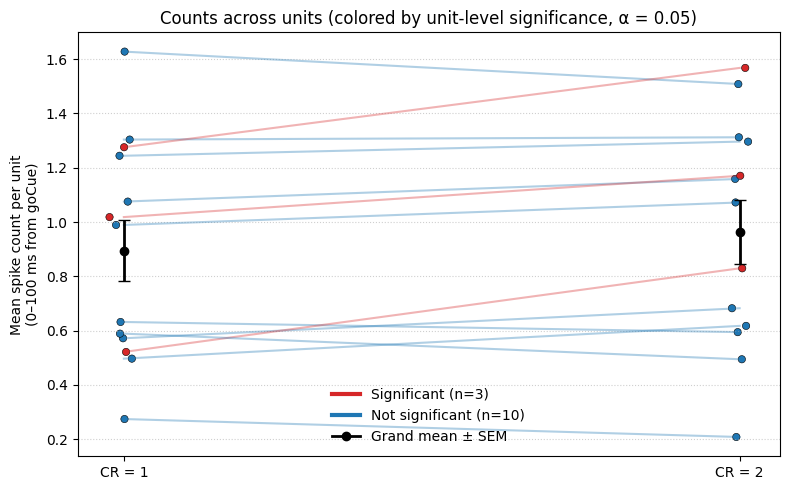

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from matplotlib.lines import Line2D

# -----------------------------
# Settings
# -----------------------------
ALIGN_KEY   = "goCue"
COUNT_WIN   = (0.0, 0.100)   # seconds
ALPHA       = 0.05
FIG_PATH    = Path("/root/capsule/scratch/figures/LC_counts_across_units.png")

# -----------------------------
# Filter summary dataframe
# -----------------------------
df = all_stats_df.copy()

mask = (
    (df["align_key"] == ALIGN_KEY) &
    (np.isclose(df["win_start_s"], COUNT_WIN[0])) &
    (np.isclose(df["win_stop_s"], COUNT_WIN[1]))
)
df = df.loc[mask].dropna(subset=["mean_count_cr1","mean_count_cr2","p_value"]).reset_index(drop=True)

# Flag significance
df["sig"] = df["p_value"] < ALPHA

# Paired vectors for across-unit test
m1 = df["mean_count_cr1"].to_numpy()
m2 = df["mean_count_cr2"].to_numpy()
diff = m1 - m2

# -----------------------------
# Grand (across-unit) Wilcoxon
# -----------------------------
if len(diff) == 0:
    raise ValueError("No units available after filtering. Check ALIGN_KEY/COUNT_WIN.")

w_stat, w_p = wilcoxon(m1, m2, alternative="two-sided", zero_method="wilcox")

grand = {
    "n_units": len(diff),
    "mean_diff_CR1_minus_CR2": float(np.mean(diff)),
    "median_diff": float(np.median(diff)),
    "wilcoxon_W": float(w_stat),
    "wilcoxon_p": float(w_p),
}

print("=== Across-unit (grand) test ===")
for k, v in grand.items():
    print(f"{k}: {v}")

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 5))

x1, x2 = 0.0, 1.0
rng = np.random.default_rng(0)
x_jit1 = x1 + rng.normal(0, 0.01, size=len(df))
x_jit2 = x2 + rng.normal(0, 0.01, size=len(df))

# Colors: significant vs not
c_sig = np.array(["C3" if s else "C0" for s in df["sig"]])  # orange = sig, blue = not

# Paired lines
for i in range(len(df)):
    ax.plot([x1, x2], [m1[i], m2[i]], color=c_sig[i], alpha=0.35, linewidth=1.5)

# Scatter
ax.scatter(x_jit1, m1, s=28, edgecolor="black", linewidth=0.4, c=c_sig)
ax.scatter(x_jit2, m2, s=28, edgecolor="black", linewidth=0.4, c=c_sig)

# Group mean ± SEM
def mean_sem(a):
    a = np.asarray(a, float)
    return np.nanmean(a), np.nanstd(a, ddof=1) / np.sqrt(np.sum(~np.isnan(a)))

m1_mean, m1_sem = mean_sem(m1)
m2_mean, m2_sem = mean_sem(m2)

ax.errorbar([x1, x2], [m1_mean, m2_mean], yerr=[m1_sem, m2_sem],
            fmt="o", markersize=6, capsize=4, linewidth=2, color="black", zorder=5,
            label="Grand mean ± SEM")

# Cosmetics
ax.set_xticks([x1, x2])
ax.set_xticklabels(["CR = 1", "CR = 2"])
ax.set_ylabel("Mean spike count per unit\n({:.0f}–{:.0f} ms from {})".format(
    COUNT_WIN[0]*1e3, COUNT_WIN[1]*1e3, ALIGN_KEY
))
ax.set_title(f"Counts across units (colored by unit-level significance, α = {ALPHA:.2f})")
ax.grid(True, axis="y", linestyle=":", alpha=0.6)

# Legend
legend_elems = [
    Line2D([0], [0], color="C3", lw=3, label=f"Significant (n={int(df['sig'].sum())})"),
    Line2D([0], [0], color="C0", lw=3, label=f"Not significant (n={int((~df['sig']).sum())})"),
    Line2D([0], [0], color="black", marker="o", lw=2, label="Grand mean ± SEM"),
]
ax.legend(handles=legend_elems, frameon=False, loc="best")

plt.tight_layout()
plt.show()
# FIG_PATH.parent.mkdir(parents=True, exist_ok=True)
# plt.savefig(FIG_PATH, dpi=300, bbox_inches="tight")
# plt.close(fig)

# print(f"✅ Saved figure: {FIG_PATH}")


In [12]:
# ---------- config ----------
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from typing import Dict, Iterable, Tuple

@dataclass
class AnalysisConfig:
    align_key: str = "goCue"
    count_window_s: Tuple[float,float] = (0.0, 0.100)
    min_trials_per_group: int = 8
    only_cue_response_trials: bool = True

# ---------- tiny utils ----------
def count_spikes_in_window(spike_times_sorted: np.ndarray, t0: float, window: Tuple[float,float]) -> int:
    a, b = t0 + window[0], t0 + window[1]
    if not np.isfinite(a) or not np.isfinite(b):
        return 0
    i0 = np.searchsorted(spike_times_sorted, a, side="left")
    i1 = np.searchsorted(spike_times_sorted, b, side="left")
    return int(i1 - i0)

def mannwhitney_summary(x: np.ndarray, y: np.ndarray) -> dict:
    if len(x) == 0 or len(y) == 0:
        return dict(p=np.nan, U=np.nan, effect=np.nan)
    stat = mannwhitneyu(x, y, alternative="two-sided")
    eff = float(np.mean(x) - np.mean(y))
    return dict(p=float(stat.pvalue), U=float(stat.statistic), effect=eff)

# ---------- session stage ----------
def build_trial_features(movs: pd.DataFrame,
                         licks: pd.DataFrame,
                         df_trials: pd.DataFrame) -> pd.DataFrame:
    """
    Return per-trial features:
      - cue_response_movement_number (Int64)
      - reaction_time_firstmove (s)
      - reaction_time_cueresponse (s)

    Will (re)annotate movements if required columns are missing.
    """
    tm = movs.copy()

    # If any required columns are missing, (re)annotate
    required_cols = {
        "cue_response_movement_number",
        "movement_latency_from_go",
        "movement_number_in_trial",
        "cue_response",
    }
    if not required_cols.issubset(tm.columns):
        tm = add_lick_metadata_to_movements(tm, licks, fields=["timestamps"]).rename(
            columns={"timestamps": "lick_time"}
        )
        tm = annotate_movement_timing(tm, df_trials)

    # ---- Per-trial features ----
    # CRMN: identical within a trial by construction
    crmn = (
        tm.groupby("trial")["cue_response_movement_number"]
          .first()
          .astype("Int64")
    )

    # First-move RT: earliest latency in each trial
    rt_first = tm.groupby("trial")["movement_latency_from_go"].min()

    # Cue-response RT: prefer explicit cue_response==True
    if "cue_response" in tm.columns:
        rt_cr = (
            tm.loc[tm["cue_response"] == True]
              .groupby("trial")["movement_latency_from_go"]
              .first()
        )
    else:
        # Fallback: match movement_number_in_trial to CRMN
        tmp = tm.copy()
        tmp["movement_number_in_trial"] = pd.to_numeric(
            tmp["movement_number_in_trial"], errors="coerce"
        ).astype("Int64")
        tmp = tmp.join(crmn.rename("crmn"), on="trial")
        rt_cr = (
            tmp.loc[tmp["movement_number_in_trial"] == tmp["crmn"]]
               .groupby("trial")["movement_latency_from_go"]
               .first()
        )

    out = pd.DataFrame({
        "cue_response_movement_number": crmn,
        "reaction_time_firstmove": rt_first,
        "reaction_time_cueresponse": rt_cr,
    })
    # Optional sanity check:
    # assert (tm.groupby("trial")["cue_response_movement_number"]
    #           .nunique(dropna=True) <= 1).all(), "Inconsistent CRMN within trial"
    return out


def make_session_bundle(session: str, cfg: AnalysisConfig):
    sdir = find_scratch_session_dir(session)
    data = load_intermediate_data(sdir)  # returns dict: {movs,trials,licks,kins}
    movs = data["movs"]
    trials = data["trials"]
    licks = data["licks"]
    kins = data["kins"]

    # time offset to convert absolute spikes → session time
    session_offset = float(trials["goCue_start_time_raw"].iloc[0])

    # events table & alignment map
    events_dict = get_events_dict(trials, licks, kins)
    E = build_event_df(events_dict)         # index: trial
    if cfg.align_key not in E.columns:
        raise KeyError(f"align_key '{cfg.align_key}' not in events table: {list(E.columns)}")
    Ev = E.dropna(subset=[cfg.align_key])
    align_times = Ev[cfg.align_key].astype(float)  # Series: trial → t0 (s)

    # purely movement-derived per-trial features
    trial_features = build_trial_features(movs, licks, trials)

    # ---- Filter to only cue-response trials (one value per trial) ----
    if cfg.only_cue_response_trials:
        cr_trials = trial_features.index[trial_features["cue_response_movement_number"].notna()]
        # keep intersection with trials that have alignment
        keep = align_times.index.intersection(cr_trials)
        align_times   = align_times.loc[keep]
        Ev            = Ev.loc[keep]
        trial_features= trial_features.loc[keep]

    return {
        "session": session,
        "Ev": Ev,
        "align_times": align_times,
        "trial_features": trial_features,
        "session_offset": session_offset,
    }

# ---------- unit stage ----------
def analyze_unit_for_session(unit_row: pd.Series, bundle: dict, cfg: AnalysisConfig):
    session = bundle["session"]
    unit_id = unit_row["unit_id"]

    # spikes → session time
    spikes = np.asarray(unit_row["spike_times"], dtype=float) - bundle["session_offset"]
    spikes.sort()

    # trials eligible for alignment
    trials = bundle["align_times"].index
    t0_map = bundle["align_times"].to_dict()

    # count per trial
    dur = cfg.count_window_s[1] - cfg.count_window_s[0]
    recs = []
    for tr in trials:
        t0 = t0_map.get(tr, np.nan)
        if not np.isfinite(t0):
            continue
        n = count_spikes_in_window(spikes, t0, cfg.count_window_s)
        recs.append({
            "unit_id": unit_id,
            "session": session,
            "trial": int(tr),
            "align_key": cfg.align_key,
            "win_start_s": cfg.count_window_s[0],
            "win_stop_s": cfg.count_window_s[1],
            "spike_count": int(n),
            "spike_rate_hz": (n / dur) if dur > 0 else np.nan,
        })
    unit_counts = pd.DataFrame(recs).set_index("trial")

    # join movement features
    tf = bundle["trial_features"]
    unit_counts = unit_counts.join(tf, how="left")  # adds CRMN + both RTs

    # per-unit stats (CR1 vs CR2)
    x = unit_counts.loc[unit_counts["cue_response_movement_number"] == 1, "spike_count"].to_numpy()
    y = unit_counts.loc[unit_counts["cue_response_movement_number"] == 2, "spike_count"].to_numpy()
    if (len(x) >= cfg.min_trials_per_group) and (len(y) >= cfg.min_trials_per_group):
        test = mannwhitney_summary(x, y)
    else:
        test = dict(p=np.nan, U=np.nan, effect=np.nan)

    unit_summary = pd.Series({
        "unit_id": unit_id,
        "session": session,
        "align_key": cfg.align_key,
        "win_start_s": cfg.count_window_s[0],
        "win_stop_s": cfg.count_window_s[1],
        "n_trials_cr1": int(len(x)),
        "n_trials_cr2": int(len(y)),
        "mean_count_cr1": float(np.mean(x)) if len(x) else np.nan,
        "mean_count_cr2": float(np.mean(y)) if len(y) else np.nan,
        "diff_means_cr1_minus_cr2": test["effect"],
        "mannwhitney_U": test["U"],
        "p_value": test["p"],
    })

    # reset index for uniform concat later
    unit_counts = unit_counts.reset_index()

    return unit_counts, unit_summary


In [13]:
cfg = AnalysisConfig(align_key="goCue", count_window_s=(0.0, 0.100), min_trials_per_group=8)
bundle_cache: Dict[str, dict] = {}

all_counts = []
all_summaries = []

for u in units_with_spikes.itertuples(index=False):
    session = u.session
    if session not in bundle_cache:
        bundle_cache[session] = make_session_bundle(session, cfg)

    unit_counts, unit_summary = analyze_unit_for_session(pd.Series(u._asdict()), bundle_cache[session], cfg)
    all_counts.append(unit_counts)
    all_summaries.append(unit_summary)

all_counts_df = pd.concat(all_counts, ignore_index=True).sort_values(["session","unit_id","trial"])
all_stats_df  = pd.DataFrame(all_summaries).sort_values(["session","unit_id"])


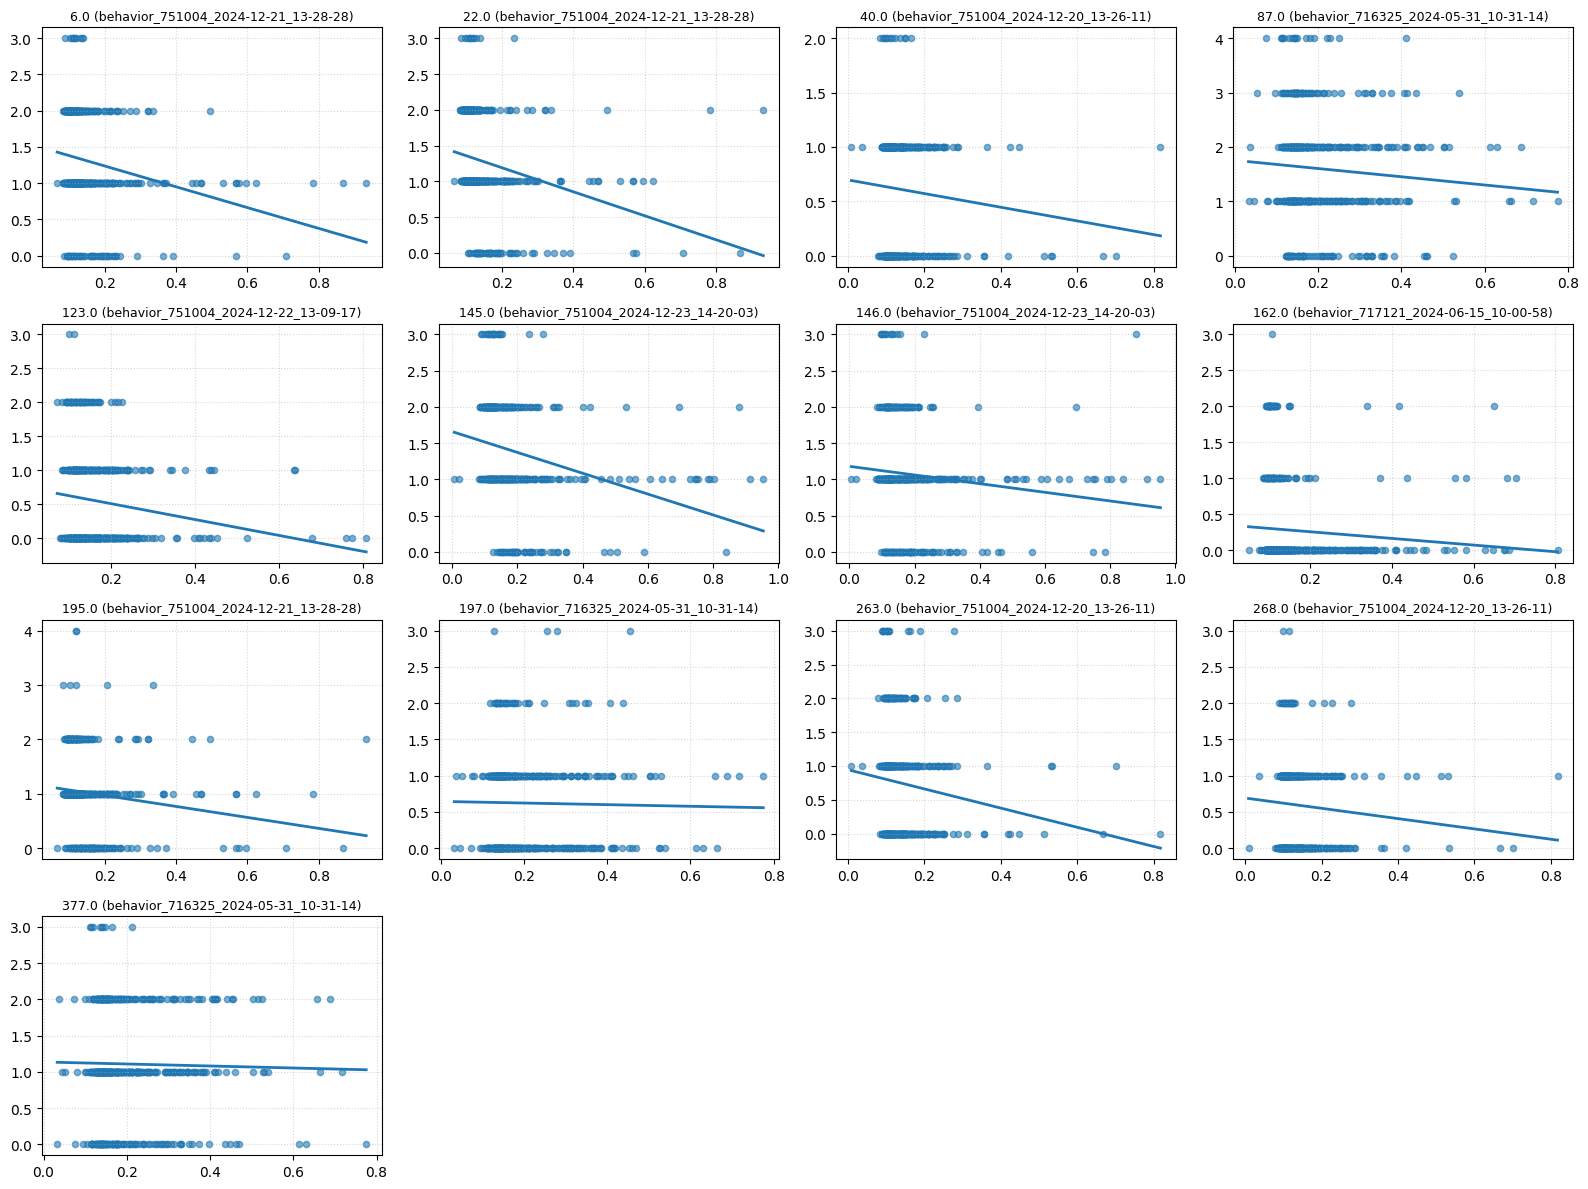

 unit_id                             session  n_trials  spearman_rho   spearman_p  pearson_r    pearson_p
    87.0 behavior_716325_2024-05-31_10-31-14       532     -0.081974 5.882882e-02  -0.080858 6.236798e-02
   197.0 behavior_716325_2024-05-31_10-31-14       532     -0.047256 2.765913e-01  -0.018034 6.781310e-01
   377.0 behavior_716325_2024-05-31_10-31-14       532     -0.017398 6.888778e-01  -0.019393 6.553800e-01
   162.0 behavior_717121_2024-06-15_10-00-58       502     -0.232955 1.297220e-07  -0.086111 5.384083e-02
    40.0 behavior_751004_2024-12-20_13-26-11       478     -0.038167 4.050831e-01  -0.089015 5.178535e-02
   263.0 behavior_751004_2024-12-20_13-26-11       478     -0.184992 4.719273e-05  -0.136605 2.763871e-03
   268.0 behavior_751004_2024-12-20_13-26-11       478     -0.137327 2.622596e-03  -0.088266 5.379401e-02
     6.0 behavior_751004_2024-12-21_13-28-28       510     -0.300873 3.936797e-12  -0.210596 1.601285e-06
    22.0 behavior_751004_2024-12-21_13-28-28  

In [ ]:
# Choose one:
rt_col = "reaction_time_firstmove"   # or "reaction_time_firstmove"

df = all_counts_df.dropna(subset=[rt_col, "spike_count"])

# Per-unit correlations + small multiples (no saving)
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

groups = list(df.groupby(["unit_id","session"]))
ncols, nrows = 4, int(np.ceil(len(groups)/4))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)

summ_rows = []
for ax, ((uid, sess), g) in zip(axes.ravel(), groups):
    x, y = g[rt_col].to_numpy(), g["spike_count"].to_numpy()
    if len(g) < 3:
        ax.axis("off"); 
        summ_rows.append({"unit_id": uid, "session": sess, "n_trials": len(g),
                          "spearman_rho": np.nan, "spearman_p": np.nan,
                          "pearson_r": np.nan, "pearson_p": np.nan})
        continue
    ax.scatter(x, y, s=20, alpha=0.6); ax.grid(True, ls=":", alpha=0.5)
    ax.set_title(f"{uid} ({sess})", fontsize=9)
    if np.unique(x).size >= 2:
        m, b = np.polyfit(x, y, 1); xx = np.linspace(np.nanmin(x), np.nanmax(x), 100); ax.plot(xx, m*xx + b, lw=2)
    # stats
    rho, ps = spearmanr(x, y, nan_policy="omit"); r, pp = pearsonr(x, y)
    summ_rows.append({"unit_id": uid, "session": sess, "n_trials": len(g),
                      "spearman_rho": float(rho), "spearman_p": float(ps),
                      "pearson_r": float(r), "pearson_p": float(pp)})

for ax in axes.ravel()[len(groups):]: ax.axis("off")
plt.tight_layout(); plt.show()

cor_df = pd.DataFrame(summ_rows).sort_values(["session","unit_id"])
print(cor_df.to_string(index=False))


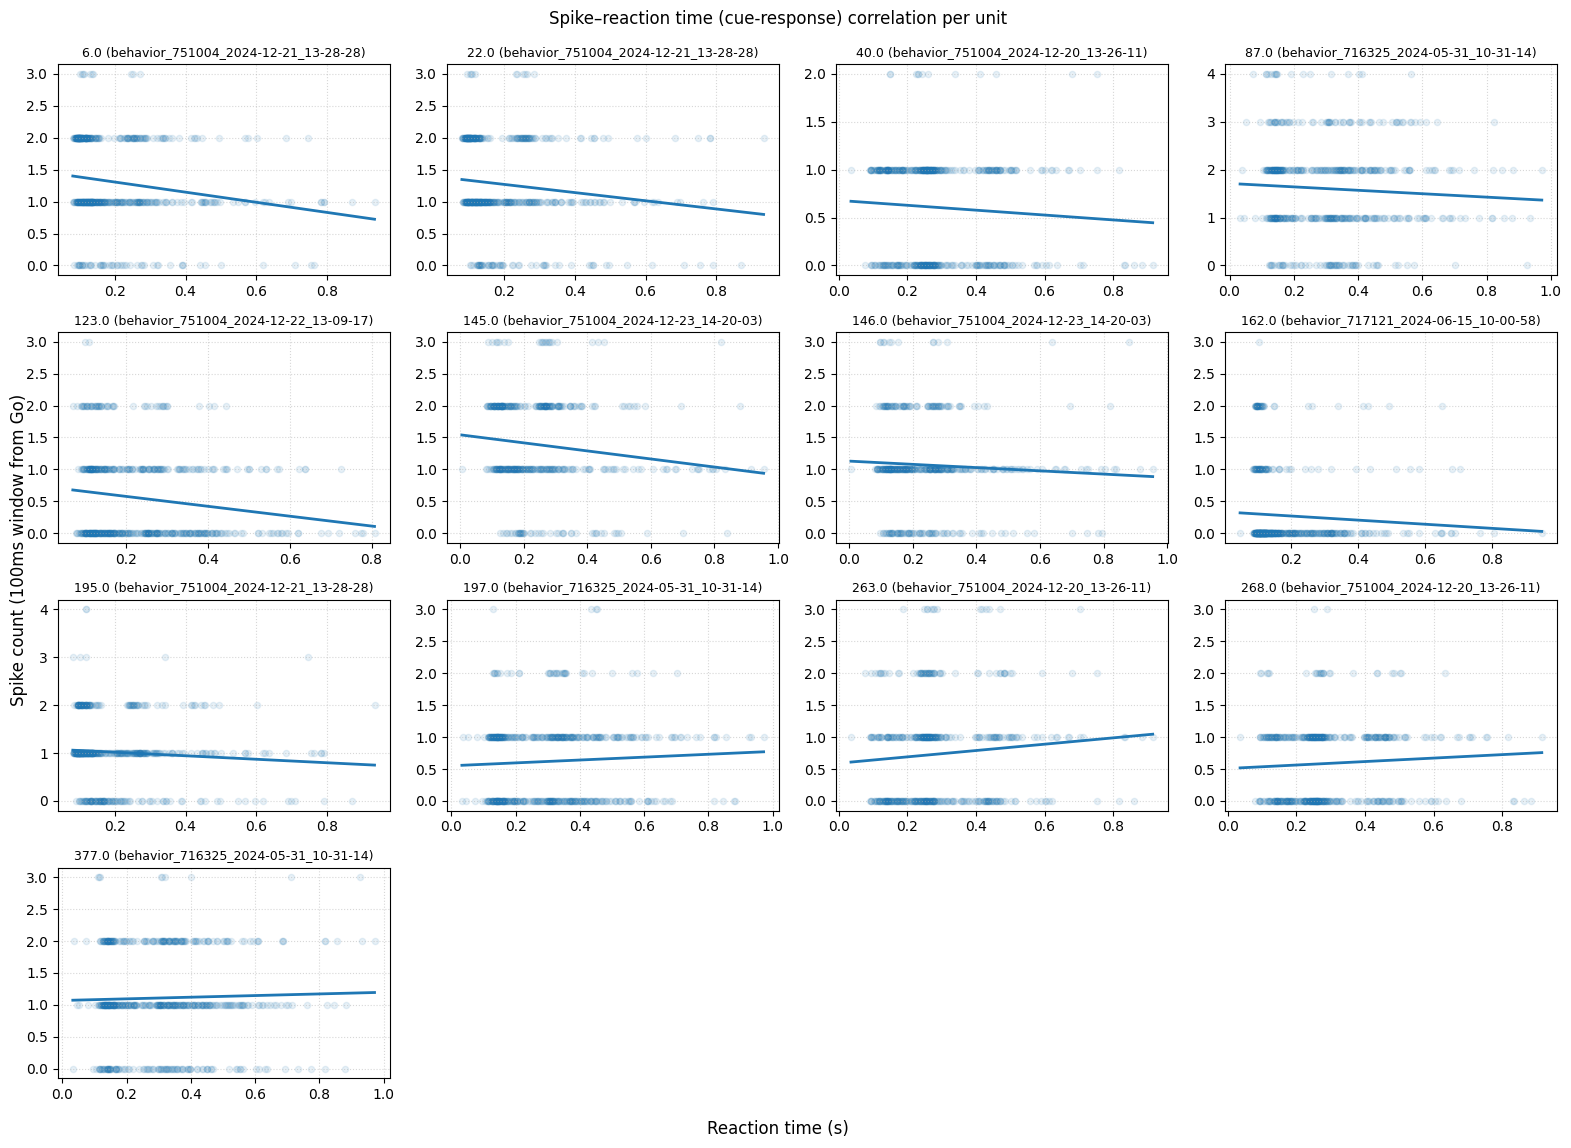

 unit_id                             session  n_trials  spearman_rho   spearman_p  pearson_r  pearson_p
    87.0 behavior_716325_2024-05-31_10-31-14       532     -0.069260 1.105647e-01  -0.063496   0.143586
   197.0 behavior_716325_2024-05-31_10-31-14       532      0.051388 2.367041e-01   0.060146   0.165972
   377.0 behavior_716325_2024-05-31_10-31-14       532      0.015586 7.198389e-01   0.029884   0.491575
   162.0 behavior_717121_2024-06-15_10-00-58       502     -0.205188 3.564886e-06  -0.070634   0.113966
    40.0 behavior_751004_2024-12-20_13-26-11       478     -0.082024 7.319099e-02  -0.070285   0.124897
   263.0 behavior_751004_2024-12-20_13-26-11       478      0.116604 1.072980e-02   0.093207   0.041660
   268.0 behavior_751004_2024-12-20_13-26-11       478      0.087765 5.517296e-02   0.065783   0.150997
     6.0 behavior_751004_2024-12-21_13-28-28       510     -0.230791 1.360416e-07  -0.171997   0.000095
    22.0 behavior_751004_2024-12-21_13-28-28       510     -0.21

In [31]:
# Choose one:
# rt_col = "reaction_time_firstmove"
rt_col = "reaction_time_cueresponse"
rt_label = {"reaction_time_firstmove": "first-move",
            "reaction_time_cueresponse": "cue-response"}.get(rt_col, rt_col)

df = all_counts_df.dropna(subset=[rt_col, "spike_count"])

# Per-unit correlations + small multiples (no saving)
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import pandas as pd

groups = list(df.groupby(["unit_id","session"]))
ncols, nrows = 4, int(np.ceil(len(groups)/4))
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)

summ_rows = []
for ax, ((uid, sess), g) in zip(axes.ravel(), groups):
    x, y = g[rt_col].to_numpy(), g["spike_count"].to_numpy()
    if len(g) < 3:
        ax.axis("off")
        summ_rows.append({"unit_id": uid, "session": sess, "n_trials": len(g),
                          "spearman_rho": np.nan, "spearman_p": np.nan,
                          "pearson_r": np.nan, "pearson_p": np.nan})
        continue

    ax.scatter(x, y, s=20, alpha=0.1)
    ax.grid(True, ls=":", alpha=0.5)
    ax.set_title(f"{uid} ({sess})", fontsize=9)

    if np.unique(x).size >= 2:
        m, b = np.polyfit(x, y, 1)
        xx = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        ax.plot(xx, m*xx + b, lw=2)

    # stats
    rho, ps = spearmanr(x, y, nan_policy="omit")
    r, pp   = pearsonr(x, y)
    summ_rows.append({"unit_id": uid, "session": sess, "n_trials": len(g),
                      "spearman_rho": float(rho), "spearman_p": float(ps),
                      "pearson_r": float(r), "pearson_p": float(pp)})

# turn off any unused axes
for ax in axes.ravel()[len(groups):]:
    ax.axis("off")

# Global labels + title
fig.supxlabel("Reaction time (s)")
fig.supylabel("Spike count (100ms window from Go)")
fig.suptitle(f"Spike–reaction time ({rt_label}) correlation per unit", y=0.95, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

cor_df = pd.DataFrame(summ_rows).sort_values(["session","unit_id"])
print(cor_df.to_string(index=False))


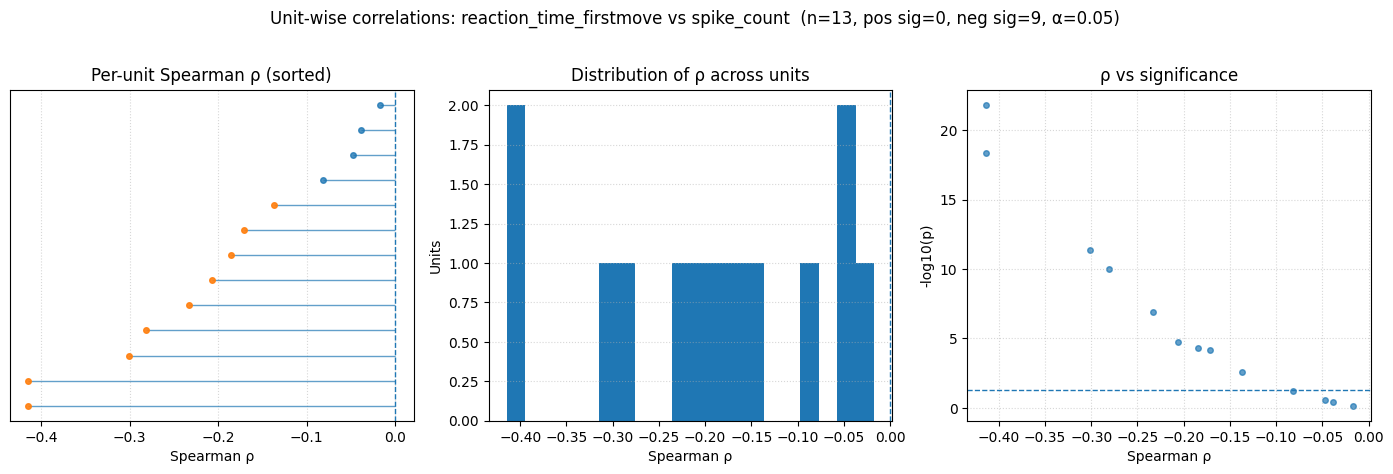

In [15]:
# Make a single summary figure from cor_df
import numpy as np
import matplotlib.pyplot as plt

ALPHA = 0.05
title_rt = rt_col  # use whichever you set above, e.g., "reaction_time_firstmove" or "reaction_time_cueresponse"

# Keep only rows with valid rho & p
valid = cor_df.dropna(subset=["spearman_rho", "spearman_p"]).copy()
if valid.empty:
    raise ValueError("No valid correlations in cor_df (all NaN).")

# Basic counts
n_units = len(valid)
sig_mask = valid["spearman_p"] < ALPHA
pos_sig = int(((valid["spearman_rho"] > 0) & sig_mask).sum())
neg_sig = int(((valid["spearman_rho"] < 0) & sig_mask).sum())

# Sort by rho for the lollipop plot
valid_sorted = valid.sort_values("spearman_rho").reset_index(drop=True)
ypos = np.arange(len(valid_sorted))

# Volcano y = -log10(p)
finite_p = valid["spearman_p"] > 0
y_volcano = -np.log10(valid.loc[finite_p, "spearman_p"].to_numpy())
x_volcano = valid.loc[finite_p, "spearman_rho"].to_numpy()
pthr_y = -np.log10(ALPHA)

# ---- Figure ----
fig, axes = plt.subplots(1, 3, figsize=(14, 4.6))

# (1) Lollipop plot of Spearman rho per unit
ax = axes[0]
rho_vals = valid_sorted["spearman_rho"].to_numpy()
is_sig_sorted = valid_sorted["spearman_p"].to_numpy() < ALPHA

# stems from 0 to rho, and markers at rho
for i, (rho, sig) in enumerate(zip(rho_vals, is_sig_sorted)):
    ax.hlines(i, 0, rho, linewidth=1.0, alpha=0.7)
# overlay markers: non-sig then sig (so sig sits on top)
ax.plot(rho_vals[~is_sig_sorted], ypos[~is_sig_sorted], "o", ms=4, alpha=0.8)
ax.plot(rho_vals[is_sig_sorted],  ypos[is_sig_sorted],  "o", ms=4, alpha=0.9)

ax.axvline(0, linestyle="--", linewidth=1)
ax.set_yticks([])
ax.set_xlabel("Spearman ρ")
ax.set_title("Per-unit Spearman ρ (sorted)")
ax.grid(True, axis="x", linestyle=":", alpha=0.5)

# (2) Histogram of rho
ax = axes[1]
ax.hist(valid["spearman_rho"].to_numpy(), bins=20)
ax.axvline(0, linestyle="--", linewidth=1)
ax.set_xlabel("Spearman ρ")
ax.set_ylabel("Units")
ax.set_title("Distribution of ρ across units")
ax.grid(True, axis="y", linestyle=":", alpha=0.5)

# (3) Volcano-style: rho vs -log10(p)
ax = axes[2]
ax.scatter(x_volcano, y_volcano, s=16, alpha=0.7)
ax.axhline(pthr_y, linestyle="--", linewidth=1)
ax.set_xlabel("Spearman ρ")
ax.set_ylabel("-log10(p)")
ax.set_title("ρ vs significance")
ax.grid(True, linestyle=":", alpha=0.5)

# Suptitle + annotation
fig.suptitle(f"Unit-wise correlations: {title_rt} vs spike_count  "
             f"(n={n_units}, pos sig={pos_sig}, neg sig={neg_sig}, α={ALPHA})", y=1.02)
plt.tight_layout()
plt.show()


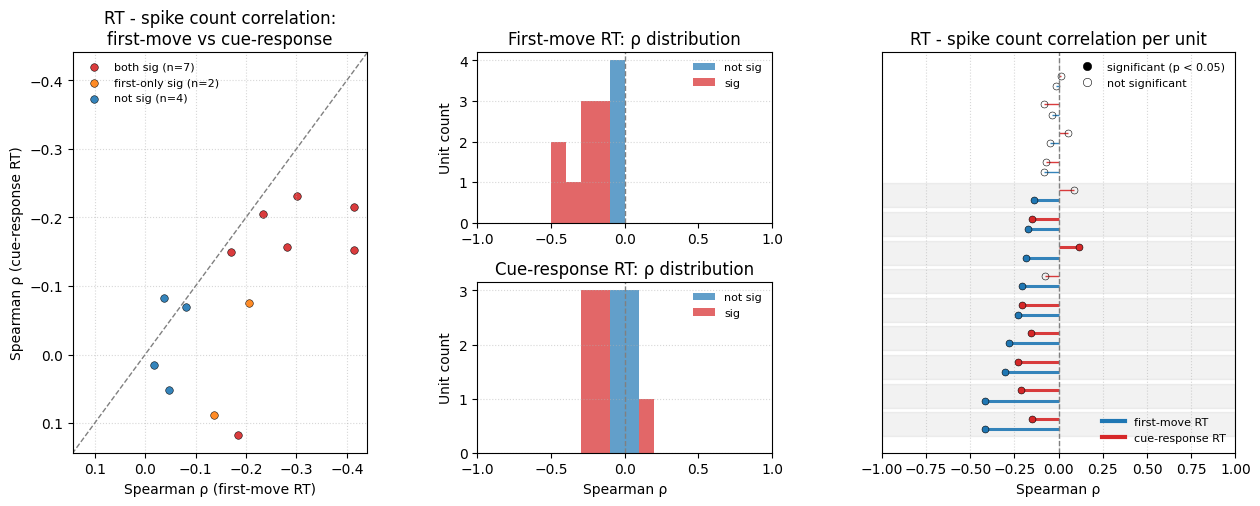

Wilcoxon on ρ (cue vs first): W=5.0, p=0.00244, mean Δρ=0.112


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, wilcoxon

# -----------------------------
# Settings (match your build of all_counts_df)
# -----------------------------
ALIGN_KEY   = "goCue"
COUNT_WIN   = (0.0, 0.100)
MIN_TRIALS_PER_UNIT = 3
ONLY_CR_TRIALS = False   # set True to keep only trials with cue_response_movement_number notna()
ALPHA = 0.05

# -----------------------------
# Prep data
# -----------------------------
df = all_counts_df.copy()
mask = (
    (df["align_key"] == ALIGN_KEY) &
    (np.isclose(df["win_start_s"], COUNT_WIN[0])) &
    (np.isclose(df["win_stop_s"], COUNT_WIN[1]))
)
df = df.loc[mask].copy()
if ONLY_CR_TRIALS:
    df = df.loc[df["cue_response_movement_number"].notna()].copy()

# -----------------------------
# Helper: per-unit Spearman for a given RT col
# -----------------------------
def per_unit_spearman(df_in: pd.DataFrame, rt_col: str) -> pd.DataFrame:
    rows = []
    for (uid, sess), g in df_in.dropna(subset=[rt_col, "spike_count"]).groupby(["unit_id","session"]):
        if len(g) < MIN_TRIALS_PER_UNIT:
            rows.append({"unit_id": uid, "session": sess, "n_trials": len(g), "rho": np.nan, "p": np.nan})
            continue
        rho, p = spearmanr(g[rt_col].to_numpy(), g["spike_count"].to_numpy(), nan_policy="omit")
        rows.append({"unit_id": uid, "session": sess, "n_trials": len(g), "rho": float(rho), "p": float(p)})
    return pd.DataFrame(rows)

# Compute correlations for both RT definitions
cor_first = per_unit_spearman(df, "reaction_time_firstmove").rename(columns={"rho":"rho_first","p":"p_first"})
cor_cr    = per_unit_spearman(df, "reaction_time_cueresponse").rename(columns={"rho":"rho_cr","p":"p_cr"})

# Keep only paired units (have both)
m = (cor_first.merge(cor_cr, on=["unit_id","session","n_trials"], how="inner")
              .dropna(subset=["rho_first","rho_cr"])
              .reset_index(drop=True))
if m.empty:
    raise ValueError("No units with valid correlations for both RT definitions.")

# Significance categories
sig_first = m["p_first"] < ALPHA
sig_cr    = m["p_cr"]    < ALPHA
m["sig_cat"] = np.select(
    [ sig_first &  sig_cr,  sig_first & ~sig_cr, ~sig_first &  sig_cr],
    [ "both sig",           "first-only sig",    "cue-only sig"        ],
    default="not sig"
)

# For panel 2
m["is_sig_first"] = sig_first
m["is_sig_cr"]    = sig_cr

# Common limits for rho axes
vals = np.concatenate([m["rho_first"].to_numpy(), m["rho_cr"].to_numpy()])
rho_min, rho_max = (np.nanmin(vals), np.nanmax(vals)) if np.isfinite(vals).all() else (-1.0, 1.0)
pad = 0.05 * (rho_max - rho_min if rho_max > rho_min else 1.0)
rho_lo, rho_hi = rho_min - pad, rho_max + pad
bins = np.linspace(min(rho_lo, -1), max(rho_hi, 1), 21)

# Colors
color_cat = {
    "both sig": "C3",          # orange/red
    "first-only sig": "C1",    # amber
    "cue-only sig": "C2",      # green
    "not sig": "C0",           # blue
}
color_rt = {"first": "C0", "cue": "C3"}  # panel 3 identity colors
color_sig = {"sig": "C3", "nonsig": "C0"}  # panel 2 significance colors

# -----------------------------
# Figure layout with nested grids
# -----------------------------
fig = plt.figure(figsize=(15, 5.2))
gs = fig.add_gridspec(nrows=2, ncols=3, width_ratios=[1.25, 1.25, 1.5], wspace=0.35, hspace=0.35)

# Panel 1: scatter with flipped axes + significance categories
ax1 = fig.add_subplot(gs[:, 0])
for k, g in m.groupby("sig_cat"):
    ax1.scatter(g["rho_first"], g["rho_cr"], s=30, alpha=0.9,
                edgecolor="black", linewidth=0.4, c=color_cat[k], label=f"{k} (n={len(g)})")
ax1.plot([rho_lo, rho_hi], [rho_lo, rho_hi], linestyle="--", linewidth=1, color="gray")

# flip both axes so "more negative" is visually "more" (upper-right)
ax1.set_xlim(rho_hi, rho_lo)
ax1.set_ylim(rho_hi, rho_lo)

ax1.set_xlabel("Spearman ρ (first-move RT)")
ax1.set_ylabel("Spearman ρ (cue-response RT)")
ax1.set_title("RT - spike count correlation:\nfirst-move vs cue-response")
ax1.grid(True, linestyle=":", alpha=0.5)
ax1.legend(frameon=False, fontsize=8, loc="best")

# Panel 2: two stacked histograms (first-move on top, cue-response bottom), colored by significance
ax2a = fig.add_subplot(gs[0, 1])  # first-move
rho_first_sig    = m.loc[m["is_sig_first"], "rho_first"].to_numpy()
rho_first_nonsig = m.loc[~m["is_sig_first"], "rho_first"].to_numpy()
ax2a.hist(rho_first_nonsig, bins=bins, alpha=0.7, label="not sig", color=color_sig["nonsig"])
ax2a.hist(rho_first_sig,    bins=bins, alpha=0.7, label="sig",     color=color_sig["sig"])
ax2a.axvline(0, linestyle="--", linewidth=1, color="gray")
ax2a.set_xlim(bins[0], bins[-1])
ax2a.set_title("First-move RT: ρ distribution")
ax2a.set_ylabel("Unit count")
ax2a.grid(True, axis="y", linestyle=":", alpha=0.5)
ax2a.legend(frameon=False, fontsize=8)

ax2b = fig.add_subplot(gs[1, 1])  # cue-response
rho_cr_sig    = m.loc[m["is_sig_cr"], "rho_cr"].to_numpy()
rho_cr_nonsig = m.loc[~m["is_sig_cr"], "rho_cr"].to_numpy()
ax2b.hist(rho_cr_nonsig, bins=bins, alpha=0.7, label="not sig", color=color_sig["nonsig"])
ax2b.hist(rho_cr_sig,    bins=bins, alpha=0.7, label="sig",     color=color_sig["sig"])
ax2b.axvline(0, linestyle="--", linewidth=1, color="gray")
ax2b.set_xlim(bins[0], bins[-1])
ax2b.set_title("Cue-response RT: ρ distribution")
ax2b.set_xlabel("Spearman ρ")
ax2b.set_ylabel("Unit count")
ax2b.grid(True, axis="y", linestyle=":", alpha=0.5)
ax2b.legend(frameon=False, fontsize=8)

# Panel 3: lollipop per unit (two RTs per unit), sorted by cue-response ρ
# Panel 3: lollipop per unit with significance highlighting
ax3 = fig.add_subplot(gs[:, 2])

# sort by cue-response rho so more negative at top (we'll keep normal y order)
order = np.argsort(m["rho_first"].to_numpy())
m_sorted = m.iloc[order].reset_index(drop=True)
y = np.arange(len(m_sorted))

offset = 0.18
for i, row in m_sorted.iterrows():
    # faint band if any significance for this unit
    if bool(row["is_sig_first"]) or bool(row["is_sig_cr"]):
        ax3.axhspan(i-0.42, i+0.42, color="k", alpha=0.05, zorder=0)

    # ---- first-move RT ----
    rf   = row["rho_first"]
    sig1 = bool(row["is_sig_first"])
    lw1  = 2.2 if sig1 else 1.0
    mfc1 = color_rt["first"] if sig1 else "none"  # filled if sig, open if not
    ax3.hlines(y=i - offset, xmin=0, xmax=rf, color=color_rt["first"], alpha=0.9, linewidth=lw1)
    ax3.plot(rf, i - offset, marker="o", markersize=5, mfc=mfc1, mec="black", mew=0.4,
             color=color_rt["first"])

    # ---- cue-response RT ----
    rc   = row["rho_cr"]
    sig2 = bool(row["is_sig_cr"])
    lw2  = 2.2 if sig2 else 1.0
    mfc2 = color_rt["cue"] if sig2 else "none"
    ax3.hlines(y=i + offset, xmin=0, xmax=rc, color=color_rt["cue"], alpha=0.9, linewidth=lw2)
    ax3.plot(rc, i + offset, marker="o", markersize=5, mfc=mfc2, mec="black", mew=0.4,
             color=color_rt["cue"])

ax3.axvline(0, linestyle="--", linewidth=1, color="gray")
ax3.set_xlim(bins[0], bins[-1])
ax3.set_ylim(-1, len(y))
ax3.set_yticks([])
ax3.set_xlabel("Spearman ρ")
ax3.set_title("RT - spike count correlation per unit")
ax3.grid(True, axis="x", linestyle=":", alpha=0.5)

# Legends: RT identity + significance style
from matplotlib.lines import Line2D
leg_rt = [
    Line2D([0], [0], color=color_rt["first"], lw=3, label="first-move RT"),
    Line2D([0], [0], color=color_rt["cue"],   lw=3, label="cue-response RT"),
]
leg_sig = [
    Line2D([0], [0], marker="o", linestyle="None", mfc="k", mec="black", mew=0.4,
           label=f"significant (p < {ALPHA})"),
    Line2D([0], [0], marker="o", linestyle="None", mfc="none", mec="black", mew=0.4,
           label="not significant"),
]
first_legend = ax3.legend(handles=leg_rt, frameon=False, loc="lower right", fontsize=8)
ax3.add_artist(first_legend)
ax3.legend(handles=leg_sig, frameon=False, loc="upper right", fontsize=8)


plt.tight_layout()
plt.show()

# Optional quick paired test on rho_cr vs rho_first
valid = m_sorted.dropna(subset=["rho_first","rho_cr"])
if len(valid) >= 3:
    W, pW = wilcoxon(valid["rho_cr"].to_numpy(), valid["rho_first"].to_numpy(), zero_method="wilcox")
    print(f"Wilcoxon on ρ (cue vs first): W={W:.1f}, p={pW:.3g}, mean Δρ={(valid['rho_cr']-valid['rho_first']).mean():.3f}")


In [ ]:
# events_dict = {
#     'goCue': (
#         df_trials,
#         'goCue_start_time_in_session',
#         'trial'
#     ),
#     'firstLick': (
#         df_licks,
#         'timestamps',
#         'trial',
#         {'cue_response': True}   # Only include cue-response licks
#     ),
#     'firstMove': (
#         tongue_kinematics,
#         'time_in_session',
#         'trial',
#         {'min_after_cue': True}  # Only movements after go cue
#     ),
#     'reward': (
#         df_trials,
#         'reward_time_in_session',
#         'trial'
#         # No filters needed unless you want to restrict rewarded trials
#     )
# }


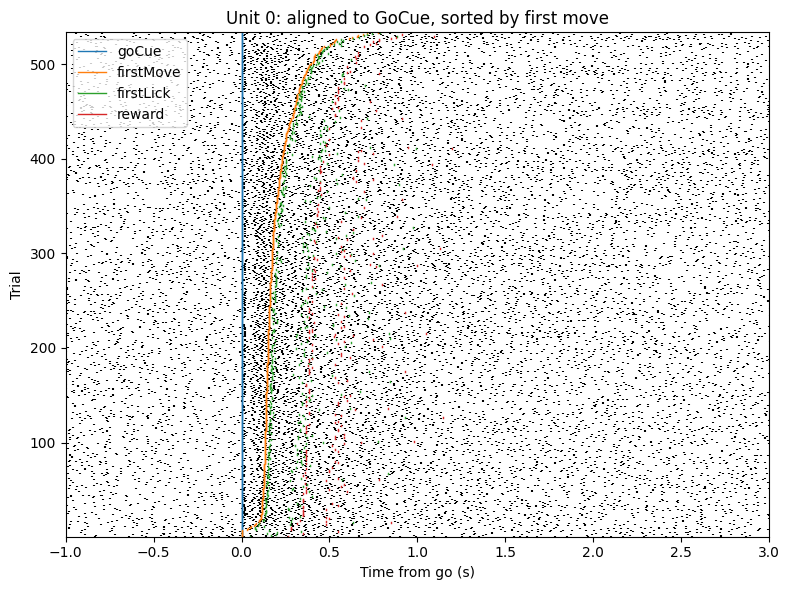

In [21]:
### example script demonstrating rasterplotter class

# 1) Prepare events df
events_dict = get_events_dict(df_trials, df_licks, tongue_kinematics)
E = build_event_df(events_dict=events_dict)

# 2) Choose trials (e.g., those with all events)
mask = E[['goCue','firstLick','firstMove']].notna().all(axis=1)
Ev = E.loc[mask]

# e.g. sort by firstLick - goCue
Ev = Ev.assign(Latency = Ev['firstMove'] - Ev['goCue'])
Ev = Ev.sort_values('Latency')
ordered_trials = Ev.index.tolist()

# 3) Create RasterPlotter for unit 0, aligned to goCue
# spikes = ephys_data.iloc[0]['spike_times_in_session']
spikes = spike_times_in_session
rp = RasterPlotter(
    spikes,
    ordered_trials,
    E['goCue'],
    pre=3,
    post=10,
    bin_size=0.001
)

# 4) Define overlay events, times, and styles
# Subtract goCue timing to get relative times for plotting
Rel = Ev[['goCue','firstLick','firstMove','reward']].subtract(Ev['goCue'], axis=0)
events = {}
colors = {'goCue':'C0','firstMove':'C1','firstLick':'C2','reward':'C3'}
for name in ['goCue','firstMove','firstLick','reward']:
    times = {i: Rel.loc[tr, name] for i, tr in enumerate(ordered_trials) if pd.notna(Rel.loc[tr,name])}
    events[name] = {'times': times, 'style': {'color': colors[name], 'linestyle':'-', 'linewidth':1}}

# 5) Plot
fig, ax = plt.subplots(figsize=(8,6))
rp.plot_with_events(events, ax=ax, spike_color='black')
ax.set_title('Unit 0: aligned to GoCue, sorted by first move')
ax.set_xlabel('Time from go (s)')
ax.legend(loc='upper left')
plt.xlim(-1,3)
plt.tight_layout()
plt.show()


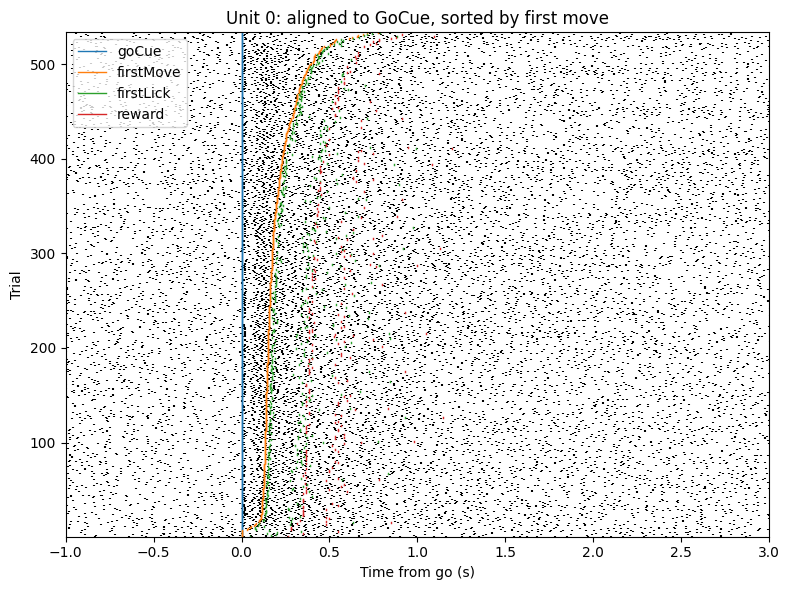

In [22]:
# 5) Plot
fig, ax = plt.subplots(figsize=(8,6))
rp.plot_with_events(events, ax=ax, spike_color='black')
ax.set_title('Unit 0: aligned to GoCue, sorted by first move')
ax.set_xlabel('Time from go (s)')
ax.legend(loc='upper left')
plt.xlim(-1,3)
plt.tight_layout()
plt.show()


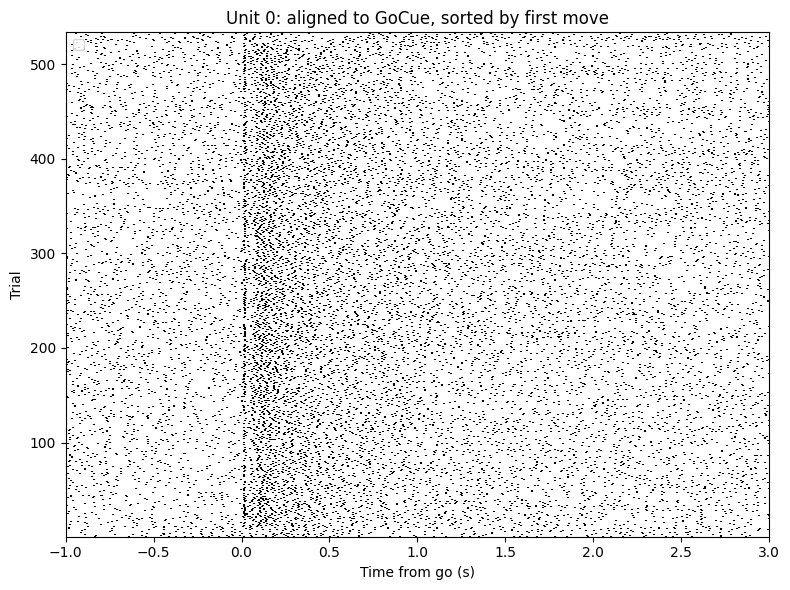

In [23]:
# 5) Plot
fig, ax = plt.subplots(figsize=(8,6))
rp.plot_raster(ax=ax)
ax.set_title('Unit 0: aligned to GoCue, sorted by first move')
ax.set_xlabel('Time from go (s)')
ax.legend(loc='upper left')
plt.xlim(-1,3)
plt.tight_layout()
plt.show()

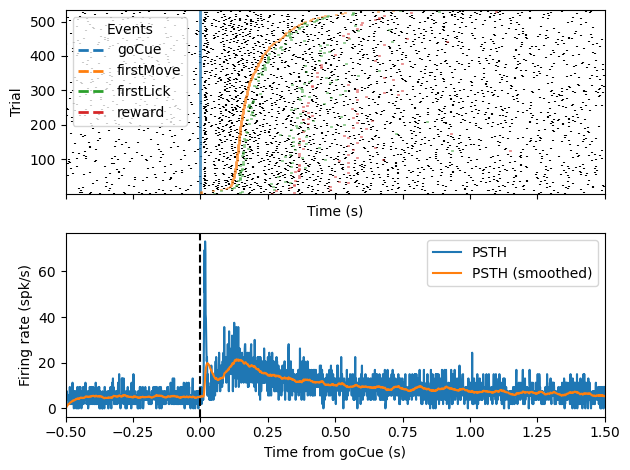

In [26]:
# once per script
E  = build_event_df(events_dict)
Ev = E.dropna(subset=['goCue','firstLick','firstMove'])
event_dicts = {n: Ev[n].to_dict() for n in Ev.columns}
trials = list(Ev.index)

# per unit
# spikes = ephys_data.iloc[0]['spike_times_in_session']
spikes = spike_times_in_session
rp, events = make_rp_and_events(
    spikes,
    trials,
    event_dicts,
    align_by='goCue',
    sort_by='firstMove',
    events_to_plot=['goCue','firstMove','firstLick','reward'],
    pre=0.5,
    post=1.5,
    bin_size=0.001
)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
rp.plot_raster(ax1)
rp.add_events(ax1, events)
ax1.legend(loc='upper left', title='Events')
psth, _  = compute_psth(rp.raster, bin_size=rp.bin_size)
psth_sm  = smooth_vector(psth, bin_size=rp.bin_size, sigma=0.025)
plot_psth(rp.bins, psth, psth_sm, ax=ax2)
ax2.set_xlabel(f"Time from goCue (s)")
plt.tight_layout()
plt.show()


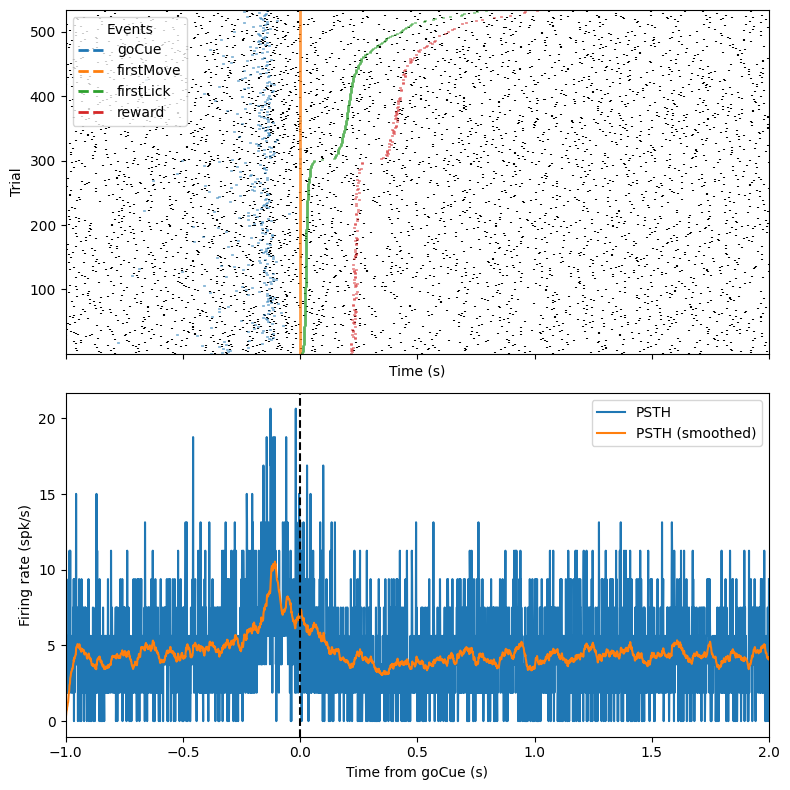

In [25]:

unit_n = 2
align_by = 'firstMove'
sort_by = 'firstLick'

# per unit
spikes = ephys_data.iloc[unit_n]['spike_times_in_session']
rp, events = make_rp_and_events(
    spikes,
    trials,
    event_dicts,
    align_by=align_by,
    sort_by=sort_by,
    events_to_plot=['goCue','firstMove','firstLick','reward'],
    pre=1,
    post=2,
    bin_size=0.001
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8,8), sharex=True)
rp.plot_raster(ax1)
rp.add_events(ax1, events)
ax1.legend(loc='upper left', title='Events')
psth, _  = compute_psth(rp.raster, bin_size=rp.bin_size)
psth_sm  = smooth_vector(psth, bin_size=rp.bin_size, sigma=0.025)
plot_psth(rp.bins, psth, psth_sm, ax=ax2)
ax2.set_xlabel(f"Time from goCue (s)")
plt.tight_layout()
plt.show()

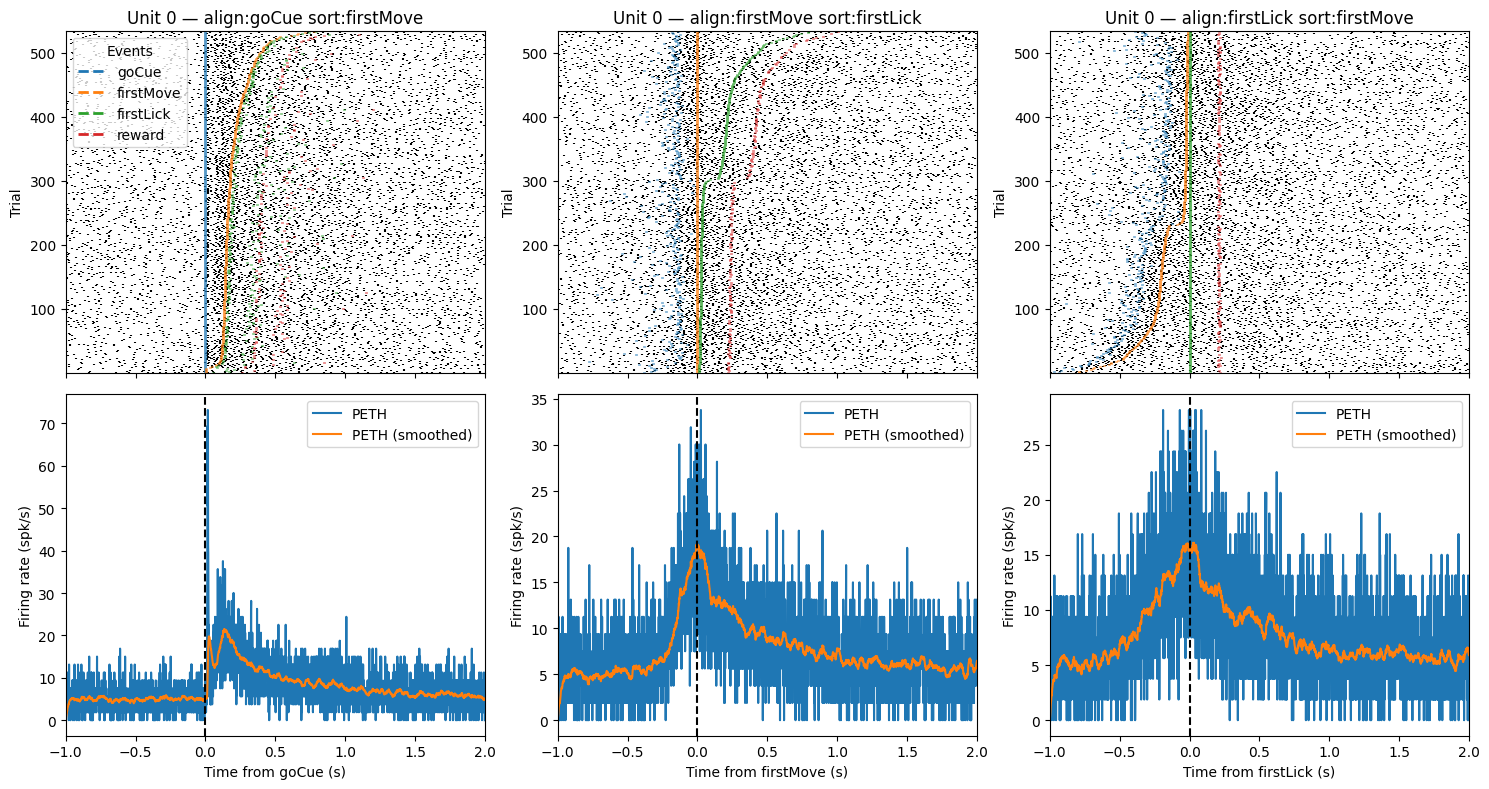

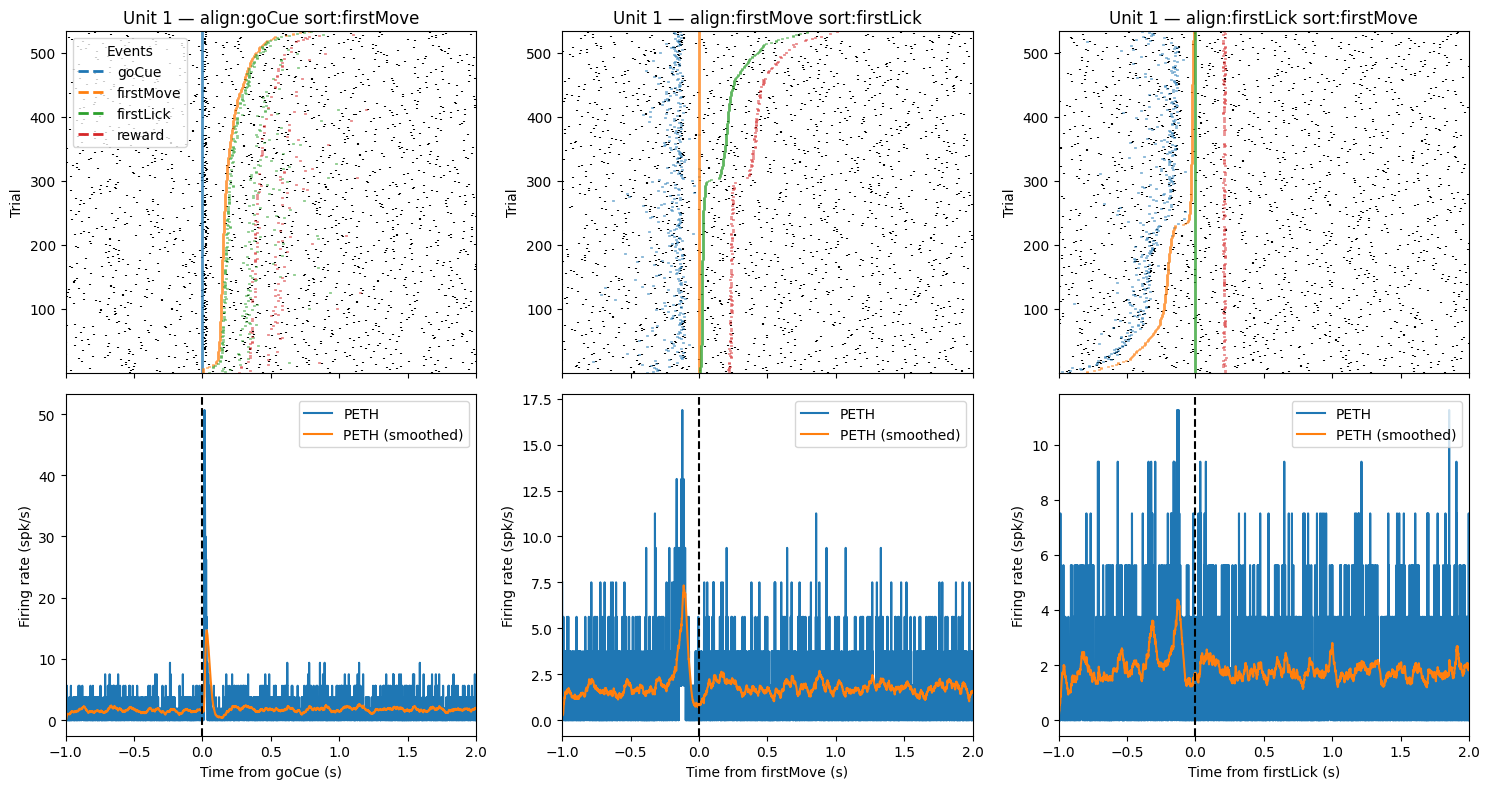

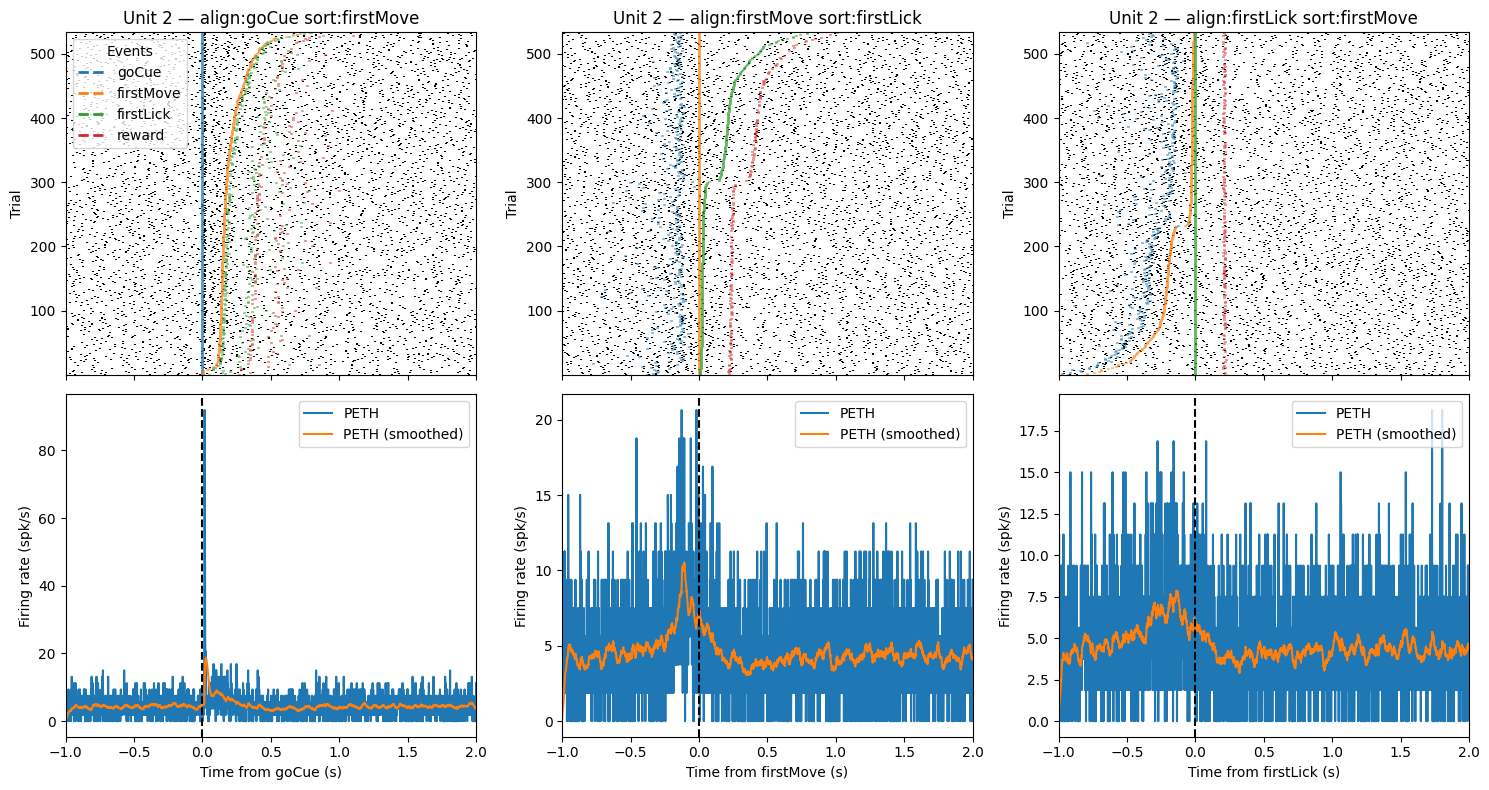

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# ————————————————————————————————————————————————
# 1) Build wide events DataFrame & filter
E  = build_event_df(events_dict)
Ev = E.dropna(subset=['goCue','firstLick','firstMove']).copy()

# ————————————————————————————————————————————————
# 2) Precompute once: trial list + event → {trial:time} mappings
trials = list(Ev.index)
event_dicts = {name: Ev[name].to_dict() for name in Ev.columns}

# ————————————————————————————————————————————————
# 3) Define the combos you want to plot
combos = [
    ('goCue',     'firstMove'),
    ('firstMove', 'firstLick'),
    ('firstLick', 'firstMove'),
]

# ————————————————————————————————————————————————
# 4) Helper to make the 2×3 figure for a single unit
def plot_unit_panels(spikes, unit_n,
                     trials,
                     event_dicts,
                     combos,
                     events_to_plot=None,
                     pre=1.0,
                     post=2.0,
                     bin_size=0.001,
                     sigma=0.025):
    """
    spikes         : 1D array of spike times
    trials         : list of trial IDs
    event_dicts    : {event_name -> {trial_id -> event_time}}
    combos         : list of (align_by, sort_by) pairs
    events_to_plot : list of event_names to overlay (defaults to all but align_by)
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex='col')

    for col, (align_by, sort_by) in enumerate(combos):
        # build the RasterPlotter + event overlays
        rp, events = make_rp_and_events(
            spikes,
            trials,
            event_dicts,
            align_by=align_by,
            sort_by=sort_by,
            events_to_plot=events_to_plot,  # or None to use all but align_by
            pre=pre,
            post=post,
            bin_size=bin_size
        )

        # top row: raster + event lines
        ax_r = axes[0, col]
        rp.plot_raster(ax=ax_r, spike_color='black')
        rp.add_events(ax_r, events)
        ax_r.set_title(f'Unit {unit_n} — align:{align_by} sort:{sort_by}')
        if col == 0:
            ax_r.set_ylabel('Trial')
            ax_r.legend(loc='upper left', title='Events')
        ax_r.set_xlabel(None)

        # bottom row: PSTH
        ax_p = axes[1, col]
        psth, _    = compute_psth(rp.raster, bin_size=rp.bin_size)
        psth_sm    = smooth_vector(psth, bin_size=rp.bin_size, sigma=sigma)
        plot_psth(rp.bins, psth, psth_sm, ax=ax_p, label='PETH')
        if col == 0:
            ax_p.set_ylabel('Firing rate (spk/s)')
        ax_p.set_xlabel(f'Time from {align_by} (s)')

    plt.tight_layout()
    return fig

# ————————————————————————————————————————————————
# 5) Loop over units and show/save
unit_list = [0,1,2]

for unit_n in unit_list:
    spikes = ephys_data.iloc[unit_n]['spike_times_in_session']
    fig = plot_unit_panels(
        spikes,
        unit_n,
        trials,
        event_dicts,
        combos,
        events_to_plot=['goCue', 'firstMove', 'firstLick', 'reward'],  # or None
        pre=1.0,
        post=2.0,
        bin_size=0.001,
        sigma=0.025
    )
    plt.show()
    # optionally: fig.savefig(f"unit_{unit_n}_panels.pdf")


In [ ]:
#splitraster for cue response movement number

#separate trials by pre-lick movement
from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import annotate_movement_timing, add_lick_metadata_to_movements

# Add lick time from licks_df
tongue_movements = add_lick_metadata_to_movements(
    tongue_movements,
    df_licks,
    fields=['timestamps']
)
tongue_movements = tongue_movements.rename(columns={'timestamps': 'lick_time'})

# Annotate movements using trials
tongue_movements = annotate_movement_timing(tongue_movements, df_trials)

In [31]:
# From your tongue_movements table
tm = tongue_movements

# Robust per-trial cue_response_movement_number (take first non-null if duplicates)
trial_crmn = (
    tm.groupby('trial')['cue_response_movement_number']
      .apply(lambda s: s.dropna().astype('Int64').iloc[0] if s.dropna().size else pd.NA)
)

trials_cr1 = set(trial_crmn[trial_crmn == 1].index.tolist())
trials_cr2 = set(trial_crmn[trial_crmn == 2].index.tolist())

# Keep only trials that exist in your events table Ev
valid_trials = set(Ev.index)
trials_cr1 = sorted(trials_cr1 & valid_trials)
trials_cr2 = sorted(trials_cr2 & valid_trials)


In [82]:
sort_key = 'firstMove'
lat = (Ev[sort_key] - Ev['goCue']).dropna()

ordered_cr1 = sorted(trials_cr1, key=lambda tr: lat.get(tr, np.inf))
ordered_cr2 = sorted(trials_cr2, key=lambda tr: lat.get(tr, np.inf))

# Combined order for the *single* raster: CR==1 first (bottom), CR==2 second (top)
combined_trials = ordered_cr1 + ordered_cr2
split_idx = len(ordered_cr1)  # row index where CR==2 starts


In [87]:
# Build align/event dicts just like your wrapper does
event_dicts = {n: Ev[n].to_dict() for n in Ev.columns}
spikes = ephys_data.iloc[0]['spike_times_in_session']

# Raster aligned to goCue, sorted by firstMove within our combined order
# (We already pre-sorted combined_trials, so pass as-is.)
align_key = 'firstLick'
align_times = event_dicts[align_key]
rp = RasterPlotter(
    spikes,
    combined_trials,
    align_times,
    pre=1.5, post=1.5, bin_size=0.001
)

# Relative event overlays (goCue, firstMove, firstLick, reward)
events = {}
for ix, name in enumerate(['goCue','firstMove','firstLick','reward']):
    times_rel = {}
    for i, tr in enumerate(combined_trials):
        t_abs = event_dicts[name].get(tr)
        t0    = align_times.get(tr)
        if t_abs is not None and t0 is not None:
            times_rel[i] = t_abs - t0
    events[name] = {'times': times_rel,
                    'style': {'color': f"C{ix}", 'linestyle':'--', 'linewidth':2}}


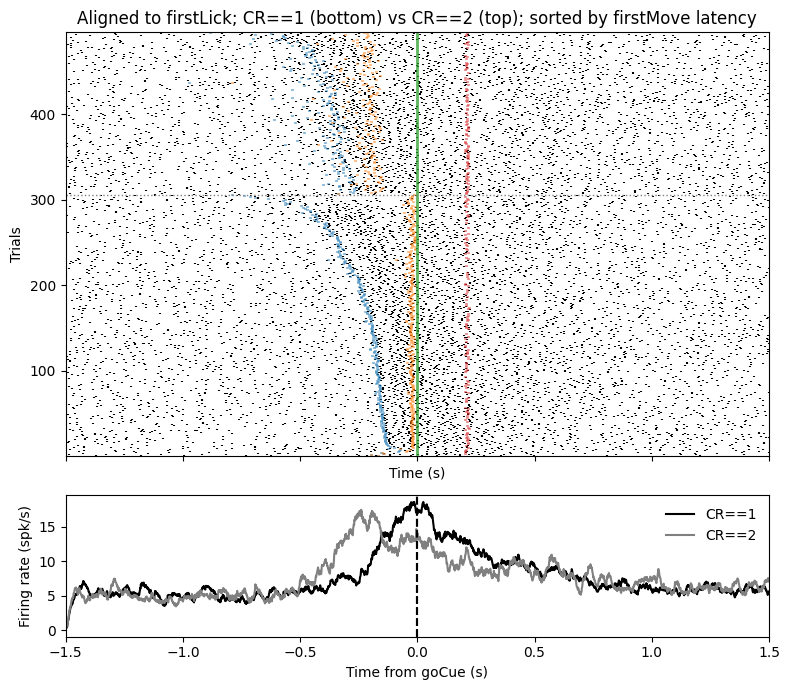

In [88]:
# Compute group PSTHs
raster_cr1 = rp.raster[:split_idx, :]   # rows corresponding to CR==1
raster_cr2 = rp.raster[split_idx:, :]   # rows corresponding to CR==2

psth1, _ = compute_psth(raster_cr1, bin_size=rp.bin_size)  # CR==1
psth2, _ = compute_psth(raster_cr2, bin_size=rp.bin_size)  # CR==2

# Smooth
psth1_sm = smooth_vector(psth1, bin_size=rp.bin_size, sigma=0.025)
psth2_sm = smooth_vector(psth2, bin_size=rp.bin_size, sigma=0.025)

# Plot with your function
fig, (ax_raster, ax_psth) = plt.subplots(2, 1, figsize=(8, 7),
                                         sharex=True,
                                         gridspec_kw={'height_ratios':[3,1]})

# Raster
rp.plot_raster(ax_raster, spike_color='black')
rp.add_events(ax_raster, events)
ax_raster.set_title(f'Aligned to {align_key}; CR==1 (bottom) vs CR==2 (top); sorted by {sort_key} latency')
ax_raster.axhline(split_idx, color='gray', linestyle=':', linewidth=1)
ax_raster.set_ylabel('Trials')

# PSTHs — only smoothed, with custom colors
plot_psth(rp.bins, psth1, psth1_sm,
          ax=ax_psth, label='CR==1',
          plot_raw=False, color='black')
plot_psth(rp.bins, psth2, psth2_sm,
          ax=ax_psth, label='CR==2',
          plot_raw=False, color='gray')

ax_psth.set_xlabel('Time from goCue (s)')
ax_psth.set_ylabel('Firing rate (spk/s)')
ax_psth.legend(frameon=False)
plt.tight_layout()
plt.show()


In [68]:
win_start, win_end = 0.0, 0.035  # seconds relative to goCue

# Find bin indices that fall in the window
bin_mask = (rp.bins >= win_start) & (rp.bins < win_end)

# Trial-wise spike counts (sum across selected bins)
counts = rp.raster[:, bin_mask].sum(axis=1)

# Split by groups
counts_cr1 = counts[:split_idx]   # CR==1
counts_cr2 = counts[split_idx:]   # CR==2


In [69]:
from scipy.stats import mannwhitneyu
stat, pval = mannwhitneyu(counts_cr1, counts_cr2, alternative='two-sided')
stat, pval

(np.float64(25109.5), np.float64(0.005174002591131878))

In [70]:
import numpy as np

observed = counts_cr1.mean() - counts_cr2.mean()
all_counts = np.concatenate([counts_cr1, counts_cr2])
n1 = len(counts_cr1)
n_perm = 10000

diffs = []
rng = np.random.default_rng()
for _ in range(n_perm):
    rng.shuffle(all_counts)
    diffs.append(all_counts[:n1].mean() - all_counts[n1:].mean())

diffs = np.array(diffs)
pval = (np.abs(diffs) >= abs(observed)).mean()
pval

np.float64(0.0062)

In [71]:
print(f"CR==1 mean: {counts_cr1.mean():.2f} spikes/trial")
print(f"CR==2 mean: {counts_cr2.mean():.2f} spikes/trial")
print(f"Permutation test p={pval:.4f}")


CR==1 mean: 0.46 spikes/trial
CR==2 mean: 0.62 spikes/trial
Permutation test p=0.0062


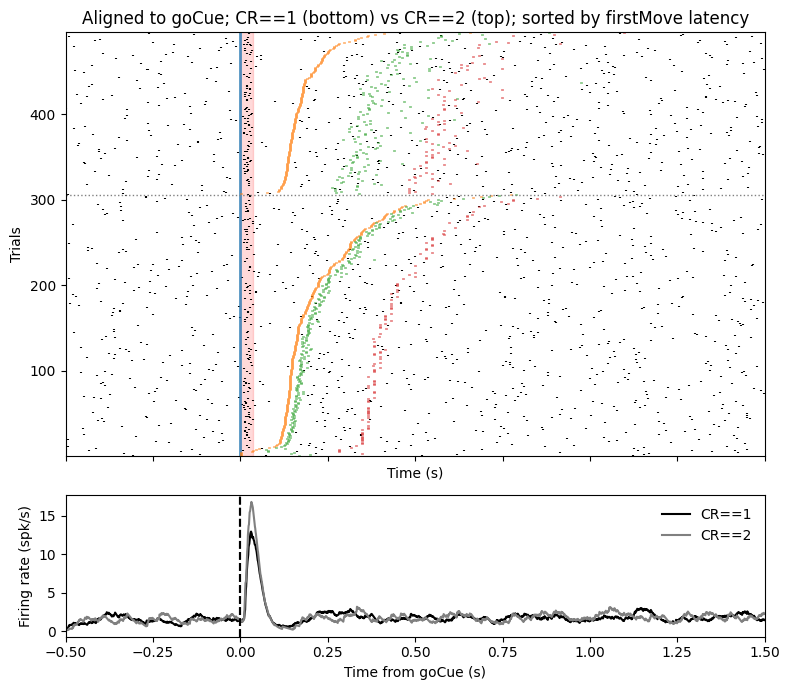

In [73]:
win_start, win_end = 0.0, 0.035  # seconds relative to goCue

# Compute group PSTHs
raster_cr1 = rp.raster[:split_idx, :]   # rows corresponding to CR==1
raster_cr2 = rp.raster[split_idx:, :]   # rows corresponding to CR==2

psth1, _ = compute_psth(raster_cr1, bin_size=rp.bin_size)  # CR==1
psth2, _ = compute_psth(raster_cr2, bin_size=rp.bin_size)  # CR==2

# Smooth
psth1_sm = smooth_vector(psth1, bin_size=rp.bin_size, sigma=0.025)
psth2_sm = smooth_vector(psth2, bin_size=rp.bin_size, sigma=0.025)

# Plot
fig, (ax_raster, ax_psth) = plt.subplots(
    2, 1, figsize=(8, 7),
    sharex=True,
    gridspec_kw={'height_ratios':[3,1]}
)

# Raster
rp.plot_raster(ax_raster, spike_color='black')
rp.add_events(ax_raster, events)
ax_raster.set_title('Aligned to goCue; CR==1 (bottom) vs CR==2 (top); sorted by firstMove latency')
ax_raster.axhline(split_idx, color='gray', linestyle=':', linewidth=1)
ax_raster.set_ylabel('Trials')

# PSTHs — only smoothed, with custom colors
plot_psth(rp.bins, psth1, psth1_sm,
          ax=ax_psth, label='CR==1',
          plot_raw=False, color='black')
plot_psth(rp.bins, psth2, psth2_sm,
          ax=ax_psth, label='CR==2',
          plot_raw=False, color='gray')

# Highlight analysis window
ax_raster.axvspan(win_start, win_end, color='red', alpha=0.15, label='Analysis window')

ax_psth.set_xlabel('Time from goCue (s)')
ax_psth.set_ylabel('Firing rate (spk/s)')
ax_psth.legend(frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
#GLM

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- 0) Ensure sorted regular grid ---
df = tongue_kinematics.sort_values('time_in_session').copy()

# Estimate frame interval (use median to be robust)
dt = np.median(np.diff(df['time_in_session'].dropna().values))  # seconds per frame

# Bin spikes on the full grid BEFORE any filtering
bins = np.append(df['time_in_session'].values,
                 df['time_in_session'].values[-1] + dt)
spike_counts, _ = np.histogram(spikes, bins=bins)
df['spike_count'] = spike_counts

# --- 1) Build time-based lags on the FULL dataframe (no dropping yet) ---
def add_time_lags(df, predictors, lag_seconds):
    """
    Add lagged columns to df by shifting rows, using the original grid.
    lag_seconds: list of non-positive lags (e.g., [0, -0.02, -0.04])
    """
    out = df.copy()
    frames_per_lag = {L: int(round(L / dt)) for L in lag_seconds}  # negative => past
    for p in predictors:
        for L in lag_seconds:
            k = frames_per_lag[L]
            out[f'{p}_lag{L:+.3f}s'] = out[p].shift(-k)  # negative L -> positive shift
    return out

predictors = ['x','y','v','xv','yv']  # what you want to use
lag_seconds = [0.0]                   # start simple; later extend like [0.0, -dt, -2*dt, ...]
df_lagged = add_time_lags(df, predictors, lag_seconds)

# --- 2) Now define the rows you’ll actually fit on ---
# Option A (strict): require current AND all lagged predictors to be present
lag_cols = [c for c in df_lagged.columns if any(c.startswith(p+'_lag') for p in predictors)]
fit_mask = df_lagged[lag_cols].notna().all(axis=1) & df_lagged['spike_count'].notna()

# This *automatically* drops rows at edges of occlusions where a lag would land in NaN.

# --- 3) Build X, y and fit GLM ---
X = df_lagged.loc[fit_mask, lag_cols]
y = df_lagged.loc[fit_mask, 'spike_count']

# (Optional) scale predictors after masking; scaling won’t break lag timing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_const = sm.add_constant(X_scaled)
model = sm.GLM(y, X_const, family=sm.families.Poisson())
results = model.fit()
print(results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            spike_count   No. Observations:               334138
Model:                            GLM   Df Residuals:                   334132
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -35001.
Date:                Fri, 12 Sep 2025   Deviance:                       55474.
Time:                        17:46:30   Pearson chi2:                 3.27e+05
No. Iterations:                     7   Pseudo R-squ. (CS):          0.0005272
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8406      0.012   -323.321      0.0

In [ ]:
import numpy as np, pandas as pd, statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

df = tongue_kinematics.sort_values('time_in_session').copy()
dt = float(np.median(np.diff(df['time_in_session'].dropna().values)))

# Bin spikes on the same grid
bins = np.append(df['time_in_session'].values, df['time_in_session'].values[-1] + dt)
spike_counts, _ = np.histogram(spikes, bins=bins)
df['spike_count'] = spike_counts

predictors = ['x','y','v','xv','yv']
lags = np.arange(-0.5, 0.5 + 1e-12, 0.02)  # seconds

def add_lag(df, col, lag_s, dt):
    k = int(np.rint(lag_s / dt))
    return df[col].shift(-k)  # negative lag -> past -> positive shift

rows = []
for L in lags:
    # Build X for this single lag (all predictors at the same lag)
    X = pd.DataFrame({f'{p}_lag{L:+.3f}s': add_lag(df, p, L, dt) for p in predictors})
    y = df['spike_count']

    mask = X.notna().all(axis=1) & y.notna()
    Xm = X.loc[mask]
    ym = y.loc[mask]

    if len(Xm) == 0:
        rows.append({'lag_s': L, 'n': 0, 'ok': False})
        continue

    # scale
    scaler = StandardScaler()
    Xs = scaler.fit_transform(Xm)

    Xc = sm.add_constant(Xs)
    model = sm.GLM(ym, Xc, family=sm.families.Poisson())
    res = model.fit()

    rows.append({
        'lag_s': L,
        'n': int(len(ym)),
        'ok': True,
        'llf': float(res.llf),
        'deviance': float(res.deviance),
        'pseudoR2_CS': float(res.null_deviance - res.deviance) / float(res.null_deviance + 1e-12)
    })
    # you can also stash full coef vectors if you want:
    # for name, b in zip(res.model.exog_names, res.params):
    #     if name != 'const': store them keyed by (L, var)

lag_sweep = pd.DataFrame(rows)


In [ ]:
import numpy as np, pandas as pd, statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- Prelim (from your setup) ---
df = tongue_kinematics.sort_values('time_in_session').copy()
dt = float(np.median(np.diff(df['time_in_session'].dropna().values)))

bins = np.append(df['time_in_session'].values, df['time_in_session'].values[-1] + dt)
spike_counts, _ = np.histogram(spikes, bins=bins)
df['spike_count'] = spike_counts

predictors = ['x','y','v','xv','yv']
lags = np.arange(-0.5, 0.5 + 1e-12, 0.01)  # seconds

def add_lag(series, lag_s, dt):
    k = int(np.rint(lag_s / dt))
    return series.shift(-k)  # negative lag -> past

# --- Sweep lags, fit one model per lag, store results ---
metrics_rows = []
coef_rows = []

for L in lags:
    # Build X for this lag (keep column names!)
    X = pd.DataFrame({f'{p}_lag{L:+.3f}s': add_lag(df[p], L, dt) for p in predictors})
    y = df['spike_count']

    mask = X.notna().all(axis=1) & y.notna()
    if not mask.any():
        metrics_rows.append({'lag_s': L, 'n': 0, 'ok': False, 'llf': np.nan,
                             'deviance': np.nan, 'null_deviance': np.nan,
                             'pseudoR2_CS': np.nan, 'aic': np.nan})
        continue

    Xm = X.loc[mask]
    ym = y.loc[mask]

    # Scale, then wrap back into a DataFrame to preserve names
    scaler = StandardScaler()
    Xs_np = scaler.fit_transform(Xm)
    Xs = pd.DataFrame(Xs_np, index=Xm.index, columns=Xm.columns)

    # Add intercept
    Xc = sm.add_constant(Xs, has_constant='add')

    res = sm.GLM(ym, Xc, family=sm.families.Poisson()).fit()

    # ---- metrics ----
    null_dev = float(res.null_deviance)
    dev = float(res.deviance)
    pseudoR2_CS = (null_dev - dev) / (null_dev + 1e-12)
    metrics_rows.append({
        'lag_s': L,
        'n': int(len(ym)),
        'ok': True,
        'llf': float(res.llf),
        'deviance': dev,
        'null_deviance': null_dev,
        'pseudoR2_CS': pseudoR2_CS,
        'aic': float(res.aic),
    })

    # ---- coefficients (exclude intercept) ----
    # Map params back to names using Xs.columns
    # res.params order == ['const'] + list(Xs.columns)
    for name, b, se, p in zip(Xs.columns, res.params[1:], res.bse[1:], res.pvalues[1:]):
        # name looks like 'xv_lag-0.200s'
        var, lag_tag = name.split('_lag')
        lag_val = float(lag_tag.replace('s', ''))  # seconds
        coef_rows.append({
            'var': var,
            'lag_s': lag_val,
            'beta': float(b),
            'se': float(se),
            'p': float(p),
            'beta_lo95': float(b - 1.96*se),
            'beta_hi95': float(b + 1.96*se),
        })

lag_metrics = pd.DataFrame(metrics_rows).sort_values('lag_s').reset_index(drop=True)
lag_coefs = pd.DataFrame(coef_rows).sort_values(['var','lag_s']).reset_index(drop=True)


ValueError: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.

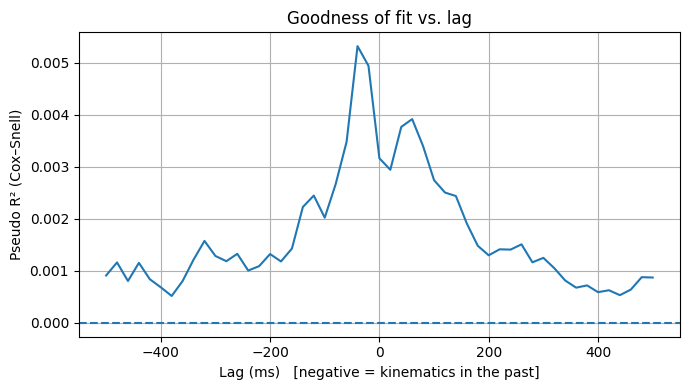

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(lag_metrics['lag_s']*1000, lag_metrics['pseudoR2_CS'])
plt.axhline(0, linestyle='--')
plt.xlabel('Lag (ms)   [negative = kinematics in the past]')
plt.ylabel('Pseudo R² (Cox–Snell)')
plt.title('Goodness of fit vs. lag')
plt.grid(True)
plt.tight_layout()
plt.show()


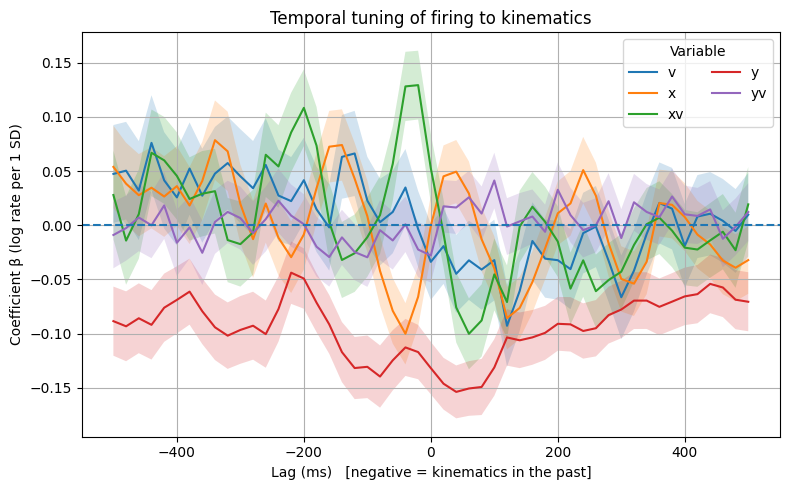

In [ ]:
# One overlayed plot: each variable gets a line + shaded CI
plt.figure(figsize=(8,5))
for var, grp in lag_coefs.groupby('var'):
    grp = grp.sort_values('lag_s')
    x = grp['lag_s']*1000  # ms
    y = grp['beta']
    lo = grp['beta_lo95']
    hi = grp['beta_hi95']
    plt.plot(x, y, label=var)
    plt.fill_between(x, lo, hi, alpha=0.2)

plt.axhline(0, linestyle='--')
plt.xlabel('Lag (ms)   [negative = kinematics in the past]')
plt.ylabel('Coefficient β (log rate per 1 SD)')
plt.title('Temporal tuning of firing to kinematics')
plt.grid(True)
plt.legend(title='Variable', ncol=2)
plt.tight_layout()
plt.show()


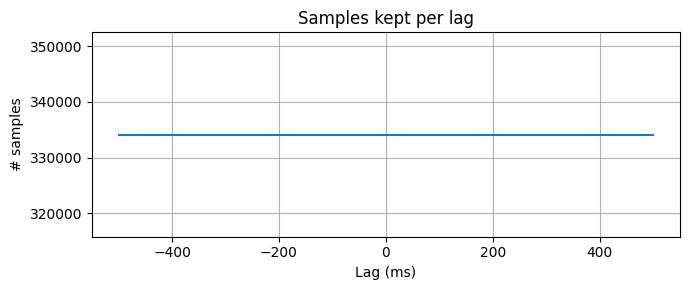

In [ ]:
plt.figure(figsize=(7,3))
plt.plot(lag_metrics['lag_s']*1000, lag_metrics['n'])
plt.xlabel('Lag (ms)'); plt.ylabel('# samples'); plt.title('Samples kept per lag')
plt.grid(True); plt.tight_layout(); plt.show()


In [45]:
import json
import pandas as pd


#mask units

# — your existing mapping from JSON keys to DataFrame columns —
col_map = {
    'isi_violations': 'isi_violations_ratio',
    # 'p_max':          'p_max',
    # 'lat_max_p':      'lat_max_p',
    # 'eu':             'euc_max_p',
    # 'corr':           'corr_max_p',
    'qc_pass':        'default_qc',
    'peak':           'peak',
    'in_df':          'real_unit',
}

# load filters
with open('/root/capsule/scratch/beh_all.json','r') as f:
    filters = json.load(f)

# initialize cumulative mask (start with all True)
mask = pd.Series(True, index=ephys_data.index)

for key, spec in filters.items():
    col = col_map.get(key)
    if col not in ephys_data.columns:
        print(f"\n no column mapped for filter '{key}' → skipping")
        continue

    print(f"\nFilter '{key}' → column '{col}':")
    series = ephys_data[col]

    # build this-filter mask
    this_mask = pd.Series(True, index=series.index)

    # bounds check
    if 'bounds' in spec:
        lo, hi = spec['bounds']
        inside_bounds = series.between(lo, hi)
        outside = (~inside_bounds & mask).sum()
        total   = mask.sum()
        this_mask &= inside_bounds
        print(f"  JSON bounds: [{lo}, {hi}]")
        print(f"  {outside}/{total} rows in the CURRENT set ({outside/total:.1%}) would be filtered by this bound")

    # membership check
    if 'items' in spec:
        allowed = set(spec['items'])
        in_items = series.isin(allowed)
        outside = (~in_items & mask).sum()
        total   = mask.sum()
        this_mask &= in_items
        print(f"  JSON items: {allowed}")
        print(f"  {outside}/{total} rows in the CURRENT set ({outside/total:.1%}) would be filtered by this membership")

    # update the cumulative mask
    mask &= this_mask

# final summary
total_units    = len(mask)
kept_units     = mask.sum()
filtered_units = total_units - kept_units
print(f"\n **FINAL**: out of {total_units} neurons, {filtered_units} ({filtered_units/total_units:.1%}) are filtered out, leaving {kept_units} units.")


FileNotFoundError: [Errno 2] No such file or directory: '/root/capsule/scratch/beh_all.json'

In [34]:
# passing_units = ephys_data[mask]
# unit_list = list(range(passing_units.shape[0]))

# with PdfPages('/root/capsule/scratch/figures/masked_units_raster_psth_alignments_recheck.pdf') as pdf:
#     for unit_n in unit_list:
#         spikes = ephys_data.iloc[unit_n]['spike_times_in_session']
#         fig = plot_unit_panels(
#             spikes,
#             unit_n,
#             trials,
#             event_dicts,
#             combos,
#             events_to_plot=['goCue', 'firstMove', 'firstLick', 'reward'],  # or None
#             pre=1.0,
#             post=2.0,
#             bin_size=0.001,
#             sigma=0.025
#         )
#         pdf.savefig(fig)
#         plt.close(fig)

# # print("✅ Saved all_units_raster_psth.pdf")

In [124]:
def plot_population_psth_heatmap(
    ephys_data,
    event_times_by_trial,  # 👈 replaces events_dict + align_event
    unit_selector_list=None,
    pre=0.5,
    post=1.5,
    bin_size=0.001,
    smooth_sigma=0.025,
    trial_subset=None,
    fr_range=None,
    cmap='viridis',
    ax=None
):
    """
    Create a population PSTH heatmap using precomputed event times.

    Parameters
    ----------
    ephys_data : DataFrame
        Must contain 'spike_times_in_session'.
    event_times_by_trial : dict
        Mapping trial numbers to alignment times (in session time).
    unit_selector_list : list
        List of unit indices or selector functions. If None, include all.
    pre, post, bin_size : float
        Time window and resolution.
    smooth_sigma : float
        Smoothing Gaussian sigma in seconds.
    trial_subset : list
        Optional subset of trials to include.
    fr_range : tuple
        (vmin, vmax) for color scale.
    cmap : str
        Matplotlib colormap name.
    ax : matplotlib Axes or None
        Axes to plot into.
    """
    if unit_selector_list is None:
        unit_selector_list = list(range(len(ephys_data)))

    valid_trials = list(event_times_by_trial.keys())
    if trial_subset is not None:
        valid_trials = list(set(valid_trials) & set(trial_subset))

    # Define bins
    n_bins = int(np.round((pre + post) / bin_size))
    bins = np.linspace(-pre, post, n_bins, endpoint=False) + bin_size / 2

    # Compute PSTHs
    psth_matrix = []
    for sel in unit_selector_list:
        unit_idx = ephys_data.index.get_loc(sel(ephys_data)) if callable(sel) else sel
        spikes = ephys_data.iloc[unit_idx]['spike_times_in_session']

        raster, _, _ = compute_raster_matrix(
            spikes,
            valid_trials,
            event_times_by_trial,
            pre=pre,
            post=post,
            bin_size=bin_size
        )
        psth, _ = compute_psth(raster, bin_size=bin_size)
        psth_smooth = smooth_vector(psth, bin_size=bin_size, sigma=smooth_sigma)
        psth_matrix.append(psth_smooth)

    psth_matrix = np.array(psth_matrix)

    # Dynamic figure sizing
    # fig_height = max(2, len(psth_matrix) * 0.15)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    else:
        fig = ax.figure

    # Plot heatmap
    im = ax.imshow(
        psth_matrix,
        interpolation='none',
        aspect='auto',
        extent=[-pre, post, 0, len(psth_matrix)],
        origin='lower',
        cmap=cmap,
        vmin=fr_range[0] if fr_range else None,
        vmax=fr_range[1] if fr_range else None
    )

    ax.axvline(0, color='k', linestyle='--')
    ax.set_ylabel('Unit #')
    ax.set_xlabel('Time from event (s)')
    ax.set_title('Population PSTH')
    plt.colorbar(im, ax=ax, label='Firing Rate (spk/s)')
    plt.tight_layout()

    return fig, ax, psth_matrix


In [81]:
unit_list = list(range(ephys_data.shape[0]))  # or custom selectors


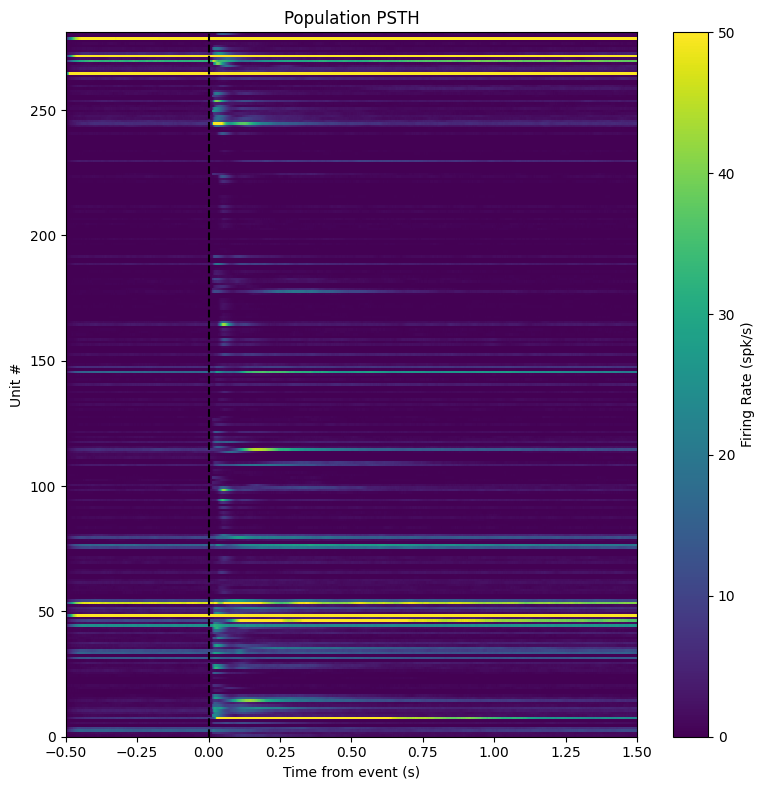

In [125]:
unit_list = list(range(ephys_data.shape[0]))  # or custom selectors
# unit_list = list(range(50))  # or custom selectors


# # Precompute event times once
# go_times = generate_event_times(*events['goCue'])
# first_lick_times = generate_event_times(*events['firstLick'], cue_times=go_times)
# first_move_times = generate_event_times(*events['firstMove'], cue_times=go_times)

event_times_by_trial = go_times

fig, ax, psth_matrix_go = plot_population_psth_heatmap(
    ephys_data,
    event_times_by_trial,
    unit_selector_list=unit_list,
    pre=0.5,
    post=1.5,
    fr_range=(0, 50)  # optional: control color scale
)
plt.show()


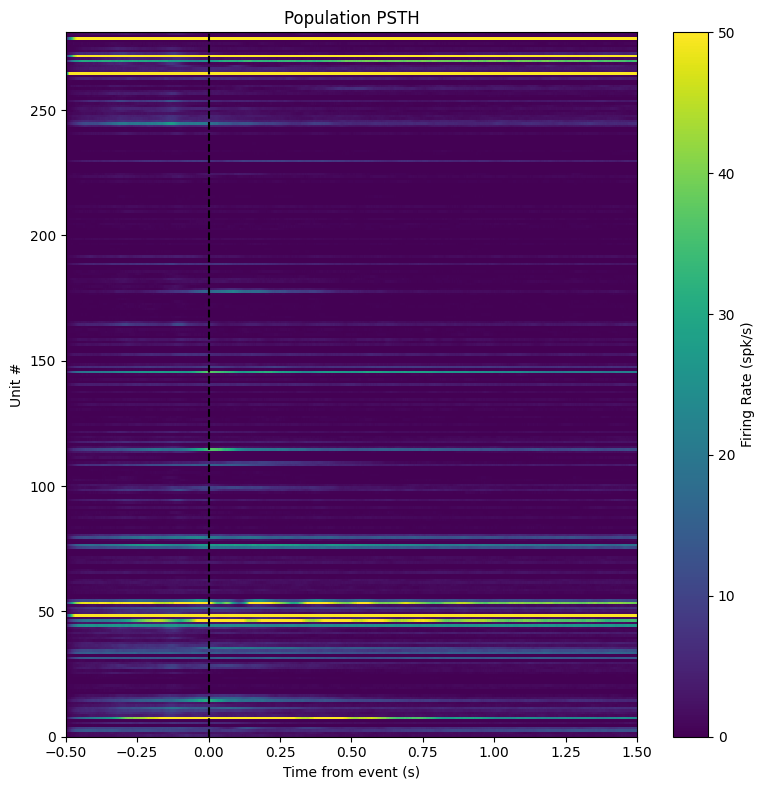

In [126]:
unit_list = list(range(ephys_data.shape[0]))  # or custom selectors
# unit_list = list(range(50))  # or custom selectors


# # Precompute event times once
# go_times = generate_event_times(*events['goCue'])
# first_lick_times = generate_event_times(*events['firstLick'], cue_times=go_times)
# first_move_times = generate_event_times(*events['firstMove'], cue_times=go_times)

event_times_by_trial = first_lick_times

fig, ax, psth_matrix_lick = plot_population_psth_heatmap(
    ephys_data,
    event_times_by_trial,
    unit_selector_list=unit_list,
    pre=0.5,
    post=1.5,
    fr_range=(0, 50)  # optional: control color scale
)
plt.show()


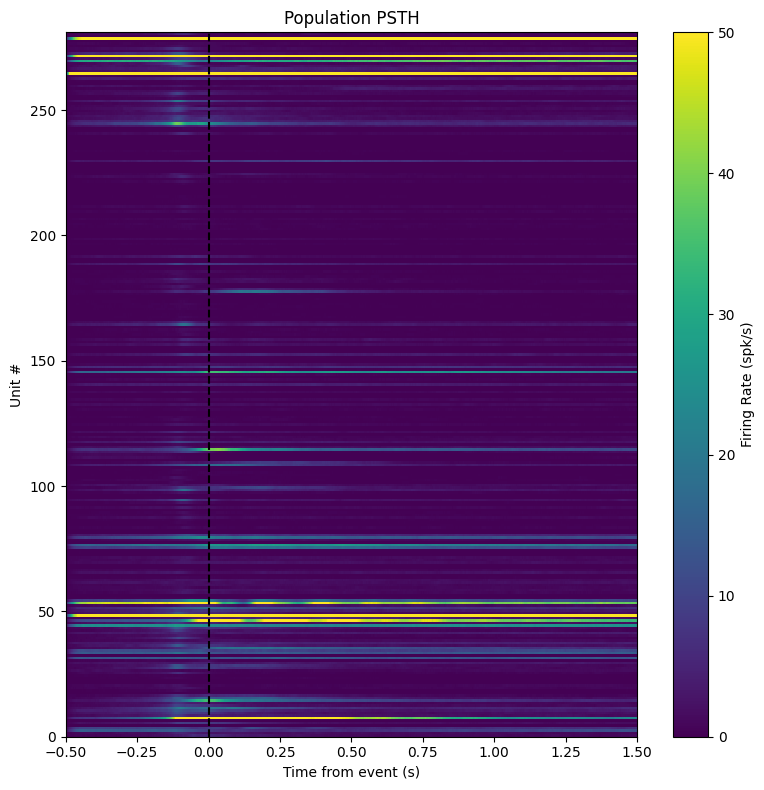

In [127]:
unit_list = list(range(ephys_data.shape[0]))  # or custom selectors
# unit_list = list(range(50))  # or custom selectors


# # Precompute event times once
# go_times = generate_event_times(*events['goCue'])
# first_lick_times = generate_event_times(*events['firstLick'], cue_times=go_times)
# first_move_times = generate_event_times(*events['firstMove'], cue_times=go_times)

event_times_by_trial = first_move_times

fig, ax, psth_matrix_move = plot_population_psth_heatmap(
    ephys_data,
    event_times_by_trial,
    unit_selector_list=unit_list,
    pre=0.5,
    post=1.5,
    fr_range=(0, 50)  # optional: control color scale
)
plt.show()


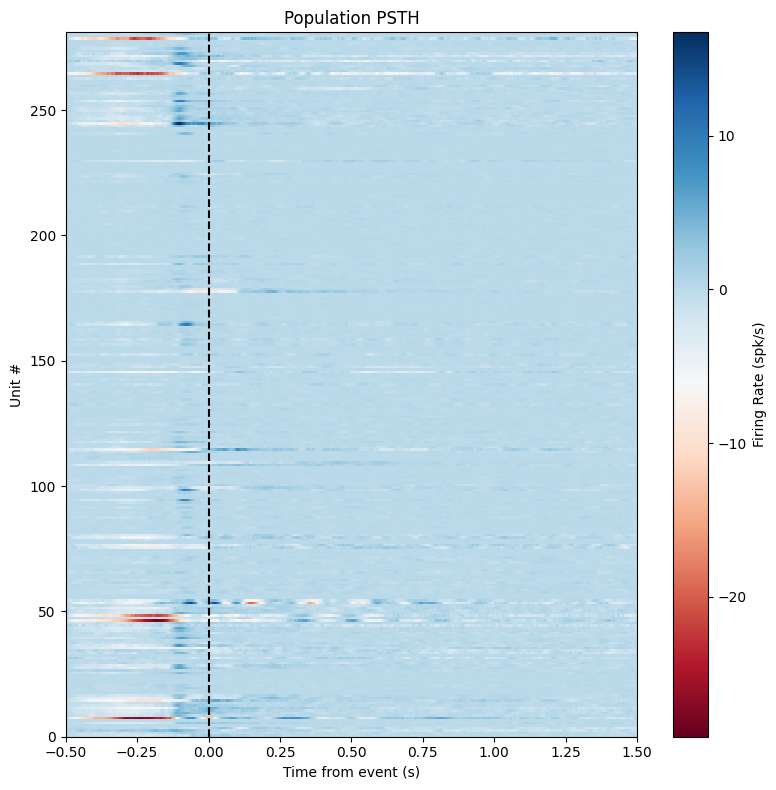

In [129]:
subtract_psth = psth_matrix_move - psth_matrix_lick
fig, ax = plt.subplots(figsize=(8, 8))

# Plot heatmap
im = ax.imshow(
    subtract_psth,
    interpolation='none',
    aspect='auto',
    extent=[-0.5, 1.5, 0, len(subtract_psth)],
    origin='lower',
    cmap='RdBu'
)

ax.axvline(0, color='k', linestyle='--')
ax.set_ylabel('Unit #')
ax.set_xlabel('Time from event (s)')
ax.set_title('delta PSTH (move - lick)')
plt.colorbar(im, ax=ax, label='delta Firing Rate (spk/s)')
plt.tight_layout()

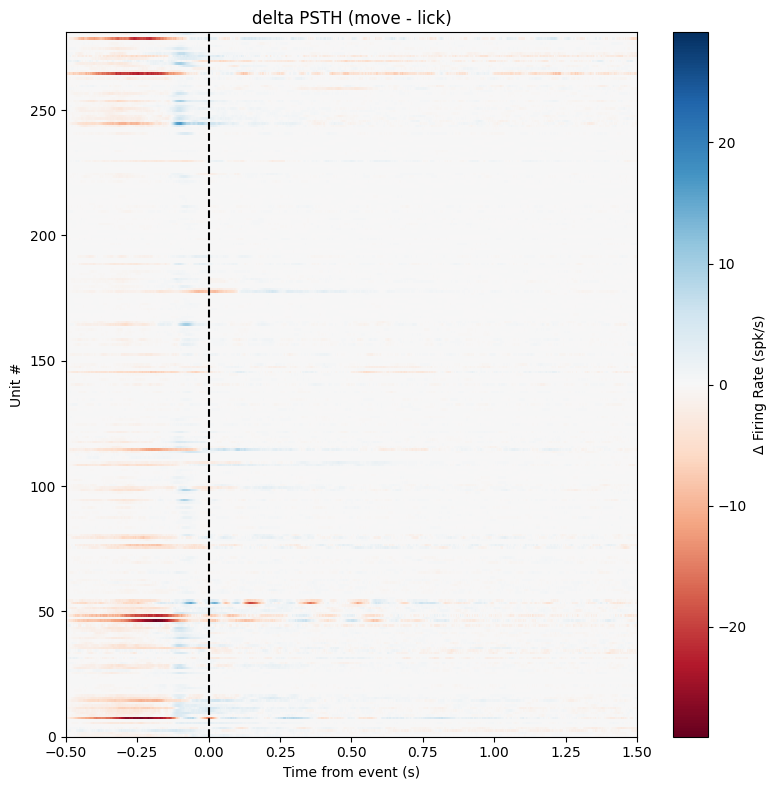

In [132]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import TwoSlopeNorm

# Example data (you can skip this if already defined)
subtract_psth = psth_matrix_move - psth_matrix_lick

# Compute symmetric range around 0
vmax = np.max(np.abs(subtract_psth))
vmin = -vmax

# Create a normalization with midpoint at 0
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(
    subtract_psth,
    interpolation='none',
    aspect='auto',
    extent=[-0.5, 1.5, 0, len(subtract_psth)],
    origin='lower',
    cmap='RdBu',
    norm=norm
)

ax.axvline(0, color='k', linestyle='--')
ax.set_ylabel('Unit #')
ax.set_xlabel('Time from event (s)')
ax.set_title('delta PSTH (move - lick)')
plt.colorbar(im, ax=ax, label='Δ Firing Rate (spk/s)')
plt.tight_layout()
plt.show()
